In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import scipy.signal


# Librerías para Clustering
from sklearn.cluster import KMeans, DBSCAN #importamos kmeans y dbsac de la libreria de clustering de sklearn
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, rand_score

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             accuracy_score,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,  # ESTE ES EL QUE USE HASTA EL MOMENTO
                             recall_score,
                             confusion_matrix)

In [2]:
from Utils import scan_folders

In [3]:
#Elección de Ejes
def plot_unsup(df_raw_data, model_name = " ", df_name=" "):
    

    #Elección de Ejes
    etiq = "etiqueta"
    clust = "Etiqueta_k"
    corr_df = df_raw_data.corr()[clust] #calculamos la correlacion
    columns = corr_df.index.values #sacamos los valores que participan en la correlacion (las columnas del df)
    corrs = abs(corr_df.values) #obtenemos los valores de la correlacion
    indexes = corrs.argsort() #argsort da los indices del arreglo ordenados para que los valores queden de menor a mayor
    #print(columns)
    #print(corrs)
    #print(indexes)
    for i in range(indexes.shape[0]-1, -1, -1): #recorremos los indices de arriba hacia abajo (ya que se ordenan de manera creciente)
        if columns[indexes[i]] != etiq and columns[indexes[i]] != clust: #el mayor indice que no sea la columna de clusters ni la de etiquetas es el primer eje
            Eje1Pos = indexes[i]
            Eje1 = columns[Eje1Pos]
            break
    for i in range(indexes.shape[0]-1, -1, -1): #el mayor indice que no sea la columna de clusters ni la de etiquetas ni la del primer eje es el segundo eje
        if columns[indexes[i]] != etiq and columns[indexes[i]] != clust and columns[indexes[i]] != Eje1:
            Eje2Pos = indexes[i]
            Eje2 = columns[Eje2Pos]
            break
    #print(Eje1)
    #print(Eje1Pos)
    #print(Eje2)
    #print(Eje2Pos)
    etiq_colors = ["white","black", "yellow","green","orange","pink","black","orange","pink"]
    clust_colors = ["blue", "green", "red","purple","grey","blue"]
    # a transformarse por los dos mas representativos o de mas peso 

    #ploteo
    fig, axs = plt.subplots(1,1)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for cl in df_raw_data[clust].unique():
        temp_df = df_raw_data.loc[df_raw_data[clust]==cl]
        axs.scatter(temp_df[Eje1],temp_df[Eje2], s=5000, alpha = 0.3, color = clust_colors[cl])
    for et in df_raw_data[etiq].unique():
        temp_df = df_raw_data.loc[df_raw_data[etiq]==et]
        axs.scatter(temp_df[Eje1],temp_df[Eje2], color = etiq_colors[et], label='etiqueta'+str(et))

    axs.set_xlabel(Eje1)
    axs.set_ylabel(Eje2)
    

    axs.set_title("Etiquetas vs Clusters" + model_name +"_"+ df_name,fontsize = 12)
    axs.legend()
    fig.show()
    
    
    spath = "C:/Users/toto_/PYTHON_TESIS/GRAPH_NOSUP/GRAPH_NOSUP_8"
    fig.savefig(spath+"/"+str(model_name) +"+"+ str(df_name)+".jpg")


    return 

In [4]:
#ESTE BLOQUE ESTA CORRECTO
def comparision_results_unsup(df_raw_data,n_etiqueta,n_clusters,model_name = " ", df_name=" "):
    
    #Ene ste bloque genero la tabla vacia a completar
    matrix = np.zeros((n_etiqueta.shape[0], n_clusters.shape[0]))
    count_kmeans= pd.DataFrame(matrix, index=list(n_etiqueta), columns=list(n_clusters))


    for fila in range(df_raw_data.shape[0]):
        count_kmeans.loc[int(df_raw_data.loc[fila,["etiqueta"]]),int(df_raw_data.loc[fila,["Etiqueta_k"]])] +=1
        
    #normalizador de contador  
    
    #En esta parte se obtienen los denominadores comunes 
    lista_denom=[]
    for fila in count_kmeans.index:
        denominador=0
        for columna in range(count_kmeans.shape[1]):

            denominador= denominador + int(count_kmeans.loc[fila,columna])

        if lista_denom is None:
            lista_denom = denominador

        else:       
            lista_denom = np.append(lista_denom, denominador)
    
    #En esta parte se genera la tabla con los resultados
    i=0
    count_kmeans_nor=count_kmeans.copy()

    for fila in count_kmeans.index:
        lista= lista_denom[i]
        #print("denominador:", lista)

        for columna in range(count_kmeans.shape[1]): 
            #print("lugar:", fila , columna, count_kmeans.loc[fila,columna] )

            if count_kmeans.loc[fila,columna] > 0:
                valor_n=((int(count_kmeans.loc[fila,columna])/lista))
            else:
                valor_n = 0
            #print("valor_n:", valor_n)
            count_kmeans_nor.loc[fila,columna] = valor_n
        i=i+1
        
    count_kmeans_nor = pd.DataFrame.from_dict(count_kmeans_nor)
    count_kmeans = pd.DataFrame.from_dict(count_kmeans)
    
    print(count_kmeans_nor)
    print(count_kmeans)
    

    #with pd.ExcelWriter('unsuppervised_models_outputs 8.xlsx', mode="a", engine="openpyxl") as writer:  
    #    count_kmeans.to_excel(writer, sheet_name= model_name +"+"+ df_name)
    
    with pd.ExcelWriter('unsuppervised_models_outputs_Normalizados 8.xlsx', mode="a", engine="openpyxl") as writer: 
        count_kmeans_nor.to_excel(writer, sheet_name= model_name +"+"+ df_name )
    
    
    
    return count_kmeans_nor, count_kmeans

In [5]:
def supervised_training_models(dataframe,score_sup, model, model_name = " ", df_name=" "):
    X = dataframe.drop(['etiqueta'], axis=1).values #lo que hace aca es guardar en x mi dataframe pero sin la columna label o etiqueta que es lo que estamos tratando de predecir. y elVALUES lo que hace es pasarme los datos de datafrme a numpy array.
    y = dataframe.etiqueta
    
    X_train,X_test,  y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3, #OJO CON ESTO, PORQUE ESTOY DEFINIENDO LO MISMO PARA TODOS LOS MODELOS
                                                        stratify=y,#lo que hace esto es que quede la misma proporcion de 0 y 1 de los label en train y test y  no lo haga tan random
                                                        random_state=123) #puedo definir una semilla de ranodm para que si despues viene otro y lo corre no le tire otro random

    model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    
    score = classification_report(y_test,y_pred_test, output_dict=True)
    df_score = pd.DataFrame(score).transpose()
    print(df_score)
    
    
    df_score_et = df_score.iloc[:-3,:]
    
    
    cnf_matrix = confusion_matrix(y_test, y_pred_test, normalize= "true")
    cnf_matrix  = pd.DataFrame(cnf_matrix,index=df_score_et.index.values,columns=df_score_et.index.values)
    Img_matrix=sn.heatmap(cnf_matrix, cmap="YlOrRd", annot=True, xticklabels=df_score_et.index.values , yticklabels=df_score_et.index.values)
    plt.title('Matriz de confusión '+ str(model_name) +"+"+ str(df_name), fontsize = 12) # title with fontsize 

    
    plt.show()
    
    figure = Img_matrix.get_figure()
    spath = "C:/Users/toto_/PYTHON_TESIS/MATRIX_CNF/MATRIX_CNF_8"
    figure.savefig(spath+"/"+str(model_name) +"+"+ str(df_name)+".jpg")

    
    with pd.ExcelWriter('matriz_confusion_8.xlsx', mode="a", engine="openpyxl") as writer:            
        cnf_matrix.to_excel(writer, sheet_name='Score'+ model_name +"+"+ df_name)
        
        
    with pd.ExcelWriter('Classification_report_8_etiquetas.xlsx', mode="a", engine="openpyxl") as writer:  
        df_score.to_excel(writer, sheet_name='Score'+ model_name +"_"+ df_name)

    score_sup.loc[df_name,model_name] = df_score.loc["macro avg","f1-score"]

    return model, score, df_score, score_sup


In [6]:
def unsupervised_training_models(dataframe,score_unsup, model, model_name = " ", df_name=" "):
    
    #preparacion
    n_etiqueta = dataframe['etiqueta'].unique()
    X = dataframe.drop(['etiqueta'], axis=1)
    y = dataframe.etiqueta.values #vector con las etiquetas
    
    #entrenamiento
    model.fit(X)
    
    Prediction = model.predict(X)
    n_clusters=np.unique(Prediction)
    dataframe.insert(0, "Etiqueta_k", Prediction) #COLUMNA DE PREDICCIÓN
    print("n_clusters", n_clusters)
       
    graph_nosup = plot_unsup(dataframe,str(model_name),str(df_name)) 
        
    RS=rand_score(y,Prediction)
    print(RS)
    score_unsup.loc[df_name,model_name] = RS
  
    count_kmeans_nor, count_kmeans = comparision_results_unsup(dataframe,n_etiqueta,n_clusters,str(model_name),str(df_name))
    
    
    return model, count_kmeans_nor, count_kmeans, score_unsup
    #return model, score_unsup

In [7]:
#BLOQUE DE DATAFRAMES (no estoy segura al final que dataframe usamos con que etiquetas)

main_path = "C:/Users/toto_/PYTHON_TESIS/Dataframe_Classifier/Dataframe_Classifier_8"

list_df = scan_folders(main_path,extension =".xlsx")


In [8]:
list_df

[['Dataframe_Classifier_8', 'df_mix_dos.xlsx'],
 ['Dataframe_Classifier_8', 'df_mix_uno.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_cinco.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_cuatro.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_diez.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_dos.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_nueve.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_ocho.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_seis.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_siete.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_tres.xlsx'],
 ['Dataframe_Classifier_8', 'stats_df_uno.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_cinco.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_cuatro.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_dos.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_ocho.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_seis.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_siete.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_tres.xlsx'],
 ['Dataframe_Classifier_8', 'wave_df_u

In [9]:
print(list_df[0][0])
print(list_df[0][1])
print(len(list_df))

Dataframe_Classifier_8
df_mix_dos.xlsx
20


In [10]:
#BLOQUE DE MODELOS

#Modelos No supervisados 
km4=KMeans(n_clusters =4 , init = 'k-means++',max_iter = 300, n_init = 10)
km3=KMeans(n_clusters =3 , init = 'k-means++',max_iter = 300, n_init = 10)
#dbscan = DBSCAN(eps=0.4, min_samples=5)


#Modelos supervisados
kn3 = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
linear_svc = svm.SVC(kernel='linear',C=100, class_weight='balanced')
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 10, class_weight = 'balanced')


datarame N°: df_mix_dos.xlsx
model KmC4
          min       max       std  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710               0.245408   
1    0.242211  0.098394 -0.018877               0.255094   
2   -0.418959  1.105769  1.011489               0.393777   
3   -0.300300  0.382823  0.596810               0.254751   
4   -2.900485  2.502953  3.157765               0.631879   
..        ...       ...       ...                    ...   
164  1.107195 -0.838128 -0.911431               0.116198   
165  0.250275 -1.121410 -0.767125               0.208037   
166  0.412712 -1.155641 -0.854059               0.205093   
167  0.783618 -0.576171 -0.634329               0.207628   
168  0.868341 -0.595235 -0.635102               0.191533   

     LATENCIA ONDA B FILT.  PENDIENTE AB  etiqueta  
0                 0.645390      0.190702         0  
1                 0.645390      0.197522         0  
2                 0.556738      0.286526         0  
3                 0.464539 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6111580726965342
         0         1         2         3
0  0.32967  0.087912  0.406593  0.175824
2  0.00000  0.285714  0.714286  0.000000
3  0.25000  0.375000  0.375000  0.000000
4  0.00000  0.473684  0.526316  0.000000
6  0.00000  0.705882  0.294118  0.000000
8  0.00000  0.962963  0.037037  0.000000
      0     1     2     3
0  30.0   8.0  37.0  16.0
2   0.0   2.0   5.0   0.0
3   2.0   3.0   3.0   0.0
4   0.0   9.0  10.0   0.0
6   0.0  12.0   5.0   0.0
8   0.0  26.0   1.0   0.0
model KmC3
          min       max       std  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710               0.245408   
1    0.242211  0.098394 -0.018877               0.255094   
2   -0.418959  1.105769  1.011489               0.393777   
3   -0.300300  0.382823  0.596810               0.254751   
4   -2.900485  2.502953  3.157765               0.631879   
..        ...       ...       ...                    ...   
164  1.107195 -0.838128 -0.911431               0.116198   
165  0.250275 -1.1214

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5637503522118906
          0         1         2
0  0.263736  0.241758  0.494505
2  0.000000  0.428571  0.571429
3  0.125000  0.375000  0.500000
4  0.000000  0.684211  0.315789
6  0.000000  1.000000  0.000000
8  0.000000  1.000000  0.000000
      0     1     2
0  24.0  22.0  45.0
2   0.0   3.0   4.0
3   1.0   3.0   4.0
4   0.0  13.0   6.0
6   0.0  17.0   0.0
8   0.0  27.0   0.0
datarame N°: df_mix_uno.xlsx
model KmC4
          min       max       std    energy  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710 -0.289680               0.245408   
1    0.242211  0.098394 -0.018877 -0.240977               0.255094   
2   -0.418959  1.105769  1.011489  0.720702               0.393777   
3   -0.300300  0.382823  0.596810  0.274762               0.254751   
4   -2.900485  2.502953  3.157765  4.275857               0.631879   
..        ...       ...       ...       ...                    ...   
164  1.107195 -0.838128 -0.911431 -0.685505               0.116198   
165  0.250275 -1.

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6131304592843054
          0         1         2         3
0  0.406593  0.153846  0.351648  0.087912
2  0.714286  0.000000  0.000000  0.285714
3  0.375000  0.000000  0.250000  0.375000
4  0.526316  0.000000  0.000000  0.473684
6  0.294118  0.000000  0.000000  0.705882
8  0.037037  0.000000  0.000000  0.962963
      0     1     2     3
0  37.0  14.0  32.0   8.0
2   5.0   0.0   0.0   2.0
3   3.0   0.0   2.0   3.0
4  10.0   0.0   0.0   9.0
6   5.0   0.0   0.0  12.0
8   1.0   0.0   0.0  26.0
model KmC3
          min       max       std    energy  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710 -0.289680               0.245408   
1    0.242211  0.098394 -0.018877 -0.240977               0.255094   
2   -0.418959  1.105769  1.011489  0.720702               0.393777   
3   -0.300300  0.382823  0.596810  0.274762               0.254751   
4   -2.900485  2.502953  3.157765  4.275857               0.631879   
..        ...       ...       ...       ...                    ...   
164 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5264158918005072
          0         1         2
0  0.318681  0.494505  0.186813
2  0.571429  0.428571  0.000000
3  0.375000  0.625000  0.000000
4  0.894737  0.105263  0.000000
6  1.000000  0.000000  0.000000
8  1.000000  0.000000  0.000000
      0     1     2
0  29.0  45.0  17.0
2   4.0   3.0   0.0
3   3.0   5.0   0.0
4  17.0   2.0   0.0
6  17.0   0.0   0.0
8  27.0   0.0   0.0
datarame N°: stats_df_cinco.xlsx
model KmC4
         mean       min       std  etiqueta
0   -0.573769  0.333366 -0.089710         0
1   -0.672474  0.242211 -0.018877         0
2   -0.652334 -0.418959  1.011489         0
3   -0.355042 -0.300300  0.596810         0
4   -1.089536 -2.900485  3.157765         0
..        ...       ...       ...       ...
164  0.253094  1.107195 -0.911431         8
165 -0.143364  0.250275 -0.767125         8
166 -0.119483  0.412712 -0.854059         8
167  0.964187  0.783618 -0.634329         8
168  1.107095  0.868341 -0.635102         8

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5860805860805861
          0         1         2         3
0  0.208791  0.197802  0.307692  0.285714
2  0.000000  0.285714  0.285714  0.428571
3  0.000000  0.000000  0.750000  0.250000
4  0.000000  0.526316  0.315789  0.157895
6  0.000000  0.647059  0.352941  0.000000
8  0.000000  1.000000  0.000000  0.000000
      0     1     2     3
0  19.0  18.0  28.0  26.0
2   0.0   2.0   2.0   3.0
3   0.0   0.0   6.0   2.0
4   0.0  10.0   6.0   3.0
6   0.0  11.0   6.0   0.0
8   0.0  27.0   0.0   0.0
model KmC3
         mean       min       std  etiqueta
0   -0.573769  0.333366 -0.089710         0
1   -0.672474  0.242211 -0.018877         0
2   -0.652334 -0.418959  1.011489         0
3   -0.355042 -0.300300  0.596810         0
4   -1.089536 -2.900485  3.157765         0
..        ...       ...       ...       ...
164  0.253094  1.107195 -0.911431         8
165 -0.143364  0.250275 -0.767125         8
166 -0.119483  0.412712 -0.854059         8
167  0.964187  0.783618 -0.634329         8
168  1.107

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5247957171034094
          0         1         2
0  0.329670  0.208791  0.461538
2  0.571429  0.000000  0.428571
3  0.375000  0.000000  0.625000
4  0.684211  0.000000  0.315789
6  1.000000  0.000000  0.000000
8  1.000000  0.000000  0.000000
      0     1     2
0  30.0  19.0  42.0
2   4.0   0.0   3.0
3   3.0   0.0   5.0
4  13.0   0.0   6.0
6  17.0   0.0   0.0
8  27.0   0.0   0.0
datarame N°: stats_df_cuatro.xlsx
model KmC4
          min       max       std    energy  etiqueta
0    0.333366  0.015322 -0.089710 -0.289680         0
1    0.242211  0.098394 -0.018877 -0.240977         0
2   -0.418959  1.105769  1.011489  0.720702         0
3   -0.300300  0.382823  0.596810  0.274762         0
4   -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431 -0.685505         8
165  0.250275 -1.121410 -0.767125 -0.638139         8
166  0.412712 -1.155641 -0.854059 -0.667660         8
167  0.783618 -0.576171 -0.63432

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6158072696534235
          0         1         2         3
0  0.087912  0.373626  0.153846  0.384615
2  0.285714  0.000000  0.000000  0.714286
3  0.375000  0.250000  0.000000  0.375000
4  0.473684  0.000000  0.000000  0.526316
6  0.705882  0.000000  0.000000  0.294118
8  0.962963  0.000000  0.000000  0.037037
      0     1     2     3
0   8.0  34.0  14.0  35.0
2   2.0   0.0   0.0   5.0
3   3.0   2.0   0.0   3.0
4   9.0   0.0   0.0  10.0
6  12.0   0.0   0.0   5.0
8  26.0   0.0   0.0   1.0
model KmC3
          min       max       std    energy  etiqueta
0    0.333366  0.015322 -0.089710 -0.289680         0
1    0.242211  0.098394 -0.018877 -0.240977         0
2   -0.418959  1.105769  1.011489  0.720702         0
3   -0.300300  0.382823  0.596810  0.274762         0
4   -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431 -0.685505         8
165  0.250275 -1.121410 -0.767125 -0.638139         8
166  0.4

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5264158918005072
          0         1         2
0  0.494505  0.318681  0.186813
2  0.428571  0.571429  0.000000
3  0.625000  0.375000  0.000000
4  0.105263  0.894737  0.000000
6  0.000000  1.000000  0.000000
8  0.000000  1.000000  0.000000
      0     1     2
0  45.0  29.0  17.0
2   3.0   4.0   0.0
3   5.0   3.0   0.0
4   2.0  17.0   0.0
6   0.0  17.0   0.0
8   0.0  27.0   0.0
datarame N°: stats_df_diez.xlsx
model KmC4
         mean       std  etiqueta
0   -0.573769 -0.089710         0
1   -0.672474 -0.018877         0
2   -0.652334  1.011489         0
3   -0.355042  0.596810         0
4   -1.089536  3.157765         0
..        ...       ...       ...
164  0.253094 -0.911431         8
165 -0.143364 -0.767125         8
166 -0.119483 -0.854059         8
167  0.964187 -0.634329         8
168  1.107095 -0.635102         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.567695125387433
          0         1         2         3
0  0.307692  0.230769  0.186813  0.274725
2  0.142857  0.571429  0.000000  0.285714
3  0.250000  0.000000  0.000000  0.750000
4  0.000000  0.736842  0.000000  0.263158
6  0.000000  0.647059  0.000000  0.352941
8  0.000000  1.000000  0.000000  0.000000
      0     1     2     3
0  28.0  21.0  17.0  25.0
2   1.0   4.0   0.0   2.0
3   2.0   0.0   0.0   6.0
4   0.0  14.0   0.0   5.0
6   0.0  11.0   0.0   6.0
8   0.0  27.0   0.0   0.0
model KmC3
         mean       std  etiqueta
0   -0.573769 -0.089710         0
1   -0.672474 -0.018877         0
2   -0.652334  1.011489         0
3   -0.355042  0.596810         0
4   -1.089536  3.157765         0
..        ...       ...       ...
164  0.253094 -0.911431         8
165 -0.143364 -0.767125         8
166 -0.119483 -0.854059         8
167  0.964187 -0.634329         8
168  1.107095 -0.635102         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5
          0         1         2
0  0.274725  0.351648  0.373626
2  0.000000  0.428571  0.571429
3  0.250000  0.250000  0.500000
4  0.105263  0.000000  0.894737
6  0.000000  0.058824  0.941176
8  0.000000  0.000000  1.000000
      0     1     2
0  25.0  32.0  34.0
2   0.0   3.0   4.0
3   2.0   2.0   4.0
4   2.0   0.0  17.0
6   0.0   1.0  16.0
8   0.0   0.0  27.0
datarame N°: stats_df_dos.xlsx
model KmC4
          min       max       std  etiqueta
0    0.333366  0.015322 -0.089710         0
1    0.242211  0.098394 -0.018877         0
2   -0.418959  1.105769  1.011489         0
3   -0.300300  0.382823  0.596810         0
4   -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431         8
165  0.250275 -1.121410 -0.767125         8
166  0.412712 -1.155641 -0.854059         8
167  0.783618 -0.576171 -0.634329         8
168  0.868341 -0.595235 -0.635102         8

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6131304592843054
          0         1         2         3
0  0.406593  0.351648  0.087912  0.153846
2  0.714286  0.000000  0.285714  0.000000
3  0.375000  0.250000  0.375000  0.000000
4  0.526316  0.000000  0.473684  0.000000
6  0.294118  0.000000  0.705882  0.000000
8  0.037037  0.000000  0.962963  0.000000
      0     1     2     3
0  37.0  32.0   8.0  14.0
2   5.0   0.0   2.0   0.0
3   3.0   2.0   3.0   0.0
4  10.0   0.0   9.0   0.0
6   5.0   0.0  12.0   0.0
8   1.0   0.0  26.0   0.0
model KmC3
          min       max       std  etiqueta
0    0.333366  0.015322 -0.089710         0
1    0.242211  0.098394 -0.018877         0
2   -0.418959  1.105769  1.011489         0
3   -0.300300  0.382823  0.596810         0
4   -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431         8
165  0.250275 -1.121410 -0.767125         8
166  0.412712 -1.155641 -0.854059         8
167  0.783618 -0.576171 -0.634329         8
168  0.868

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5593124823894055
          0         1         2
0  0.252747  0.494505  0.252747
2  0.428571  0.571429  0.000000
3  0.375000  0.500000  0.125000
4  0.684211  0.315789  0.000000
6  1.000000  0.000000  0.000000
8  1.000000  0.000000  0.000000
      0     1     2
0  23.0  45.0  23.0
2   3.0   4.0   0.0
3   3.0   4.0   1.0
4  13.0   6.0   0.0
6  17.0   0.0   0.0
8  27.0   0.0   0.0
datarame N°: stats_df_nueve.xlsx
model KmC4
          std    energy  etiqueta
0   -0.089710 -0.289680         0
1   -0.018877 -0.240977         0
2    1.011489  0.720702         0
3    0.596810  0.274762         0
4    3.157765  4.275857         0
..        ...       ...       ...
164 -0.911431 -0.685505         8
165 -0.767125 -0.638139         8
166 -0.854059 -0.667660         8
167 -0.634329 -0.585863         8
168 -0.635102 -0.585782         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6117216117216118
          0         1         2         3
0  0.153846  0.351648  0.384615  0.109890
2  0.000000  0.857143  0.000000  0.142857
3  0.000000  0.375000  0.250000  0.375000
4  0.000000  0.526316  0.000000  0.473684
6  0.000000  0.235294  0.000000  0.764706
8  0.000000  0.037037  0.000000  0.962963
      0     1     2     3
0  14.0  32.0  35.0  10.0
2   0.0   6.0   0.0   1.0
3   0.0   3.0   2.0   3.0
4   0.0  10.0   0.0   9.0
6   0.0   4.0   0.0  13.0
8   0.0   1.0   0.0  26.0
model KmC3
          std    energy  etiqueta
0   -0.089710 -0.289680         0
1   -0.018877 -0.240977         0
2    1.011489  0.720702         0
3    0.596810  0.274762         0
4    3.157765  4.275857         0
..        ...       ...       ...
164 -0.911431 -0.685505         8
165 -0.767125 -0.638139         8
166 -0.854059 -0.667660         8
167 -0.634329 -0.585863         8
168 -0.635102 -0.585782         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5001408847562694
          0         1         2
0  0.362637  0.186813  0.450549
2  0.571429  0.000000  0.428571
3  0.500000  0.000000  0.500000
4  1.000000  0.000000  0.000000
6  1.000000  0.000000  0.000000
8  1.000000  0.000000  0.000000
      0     1     2
0  33.0  17.0  41.0
2   4.0   0.0   3.0
3   4.0   0.0   4.0
4  19.0   0.0   0.0
6  17.0   0.0   0.0
8  27.0   0.0   0.0
datarame N°: stats_df_ocho.xlsx
model KmC4
          min       std  etiqueta
0    0.333366 -0.089710         0
1    0.242211 -0.018877         0
2   -0.418959  1.011489         0
3   -0.300300  0.596810         0
4   -2.900485  3.157765         0
..        ...       ...       ...
164  1.107195 -0.911431         8
165  0.250275 -0.767125         8
166  0.412712 -0.854059         8
167  0.783618 -0.634329         8
168  0.868341 -0.635102         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5941814595660749
          0         1         2         3
0  0.153846  0.296703  0.406593  0.142857
2  0.428571  0.285714  0.285714  0.000000
3  0.375000  0.625000  0.000000  0.000000
4  0.473684  0.052632  0.473684  0.000000
6  0.764706  0.000000  0.235294  0.000000
8  0.962963  0.000000  0.037037  0.000000
      0     1     2     3
0  14.0  27.0  37.0  13.0
2   3.0   2.0   2.0   0.0
3   3.0   5.0   0.0   0.0
4   9.0   1.0   9.0   0.0
6  13.0   0.0   4.0   0.0
8  26.0   0.0   1.0   0.0
model KmC3
          min       std  etiqueta
0    0.333366 -0.089710         0
1    0.242211 -0.018877         0
2   -0.418959  1.011489         0
3   -0.300300  0.596810         0
4   -2.900485  3.157765         0
..        ...       ...       ...
164  1.107195 -0.911431         8
165  0.250275 -0.767125         8
166  0.412712 -0.854059         8
167  0.783618 -0.634329         8
168  0.868341 -0.635102         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5362073823612286
          0         1         2
0  0.428571  0.307692  0.263736
2  0.571429  0.428571  0.000000
3  0.625000  0.375000  0.000000
4  0.368421  0.631579  0.000000
6  0.058824  0.941176  0.000000
8  0.000000  1.000000  0.000000
      0     1     2
0  39.0  28.0  24.0
2   4.0   3.0   0.0
3   5.0   3.0   0.0
4   7.0  12.0   0.0
6   1.0  16.0   0.0
8   0.0  27.0   0.0
datarame N°: stats_df_seis.xlsx
model KmC4
         mean       max       std  etiqueta
0   -0.573769  0.015322 -0.089710         0
1   -0.672474  0.098394 -0.018877         0
2   -0.652334  1.105769  1.011489         0
3   -0.355042  0.382823  0.596810         0
4   -1.089536  2.502953  3.157765         0
..        ...       ...       ...       ...
164  0.253094 -0.838128 -0.911431         8
165 -0.143364 -1.121410 -0.767125         8
166 -0.119483 -1.155641 -0.854059         8
167  0.964187 -0.576171 -0.634329         8
168  1.107095 -0.595235 -0.635102         8

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5791772330233869
          0         1         2         3
0  0.197802  0.197802  0.263736  0.340659
2  0.571429  0.000000  0.285714  0.142857
3  0.000000  0.000000  0.750000  0.250000
4  0.736842  0.000000  0.263158  0.000000
6  0.764706  0.000000  0.235294  0.000000
8  1.000000  0.000000  0.000000  0.000000
      0     1     2     3
0  18.0  18.0  24.0  31.0
2   4.0   0.0   2.0   1.0
3   0.0   0.0   6.0   2.0
4  14.0   0.0   5.0   0.0
6  13.0   0.0   4.0   0.0
8  27.0   0.0   0.0   0.0
model KmC3
         mean       max       std  etiqueta
0   -0.573769  0.015322 -0.089710         0
1   -0.672474  0.098394 -0.018877         0
2   -0.652334  1.105769  1.011489         0
3   -0.355042  0.382823  0.596810         0
4   -1.089536  2.502953  3.157765         0
..        ...       ...       ...       ...
164  0.253094 -0.838128 -0.911431         8
165 -0.143364 -1.121410 -0.767125         8
166 -0.119483 -1.155641 -0.854059         8
167  0.964187 -0.576171 -0.634329         8
168  1.107

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.4926739926739927
          0         1         2
0  0.296703  0.340659  0.362637
2  0.000000  0.142857  0.857143
3  0.250000  0.250000  0.500000
4  0.105263  0.000000  0.894737
6  0.000000  0.000000  1.000000
8  0.000000  0.000000  1.000000
      0     1     2
0  27.0  31.0  33.0
2   0.0   1.0   6.0
3   2.0   2.0   4.0
4   2.0   0.0  17.0
6   0.0   0.0  17.0
8   0.0   0.0  27.0
datarame N°: stats_df_siete.xlsx
model KmC4
          max       std  etiqueta
0    0.015322 -0.089710         0
1    0.098394 -0.018877         0
2    1.105769  1.011489         0
3    0.382823  0.596810         0
4    2.502953  3.157765         0
..        ...       ...       ...
164 -0.838128 -0.911431         8
165 -1.121410 -0.767125         8
166 -1.155641 -0.854059         8
167 -0.576171 -0.634329         8
168 -0.595235 -0.635102         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6260918568610876
          0         1         2         3
0  0.351648  0.197802  0.373626  0.076923
2  0.571429  0.000000  0.142857  0.285714
3  0.375000  0.125000  0.125000  0.375000
4  0.526316  0.000000  0.000000  0.473684
6  0.117647  0.000000  0.000000  0.882353
8  0.037037  0.000000  0.000000  0.962963
      0     1     2     3
0  32.0  18.0  34.0   7.0
2   4.0   0.0   1.0   2.0
3   3.0   1.0   1.0   3.0
4  10.0   0.0   0.0   9.0
6   2.0   0.0   0.0  15.0
8   1.0   0.0   0.0  26.0
model KmC3
          max       std  etiqueta
0    0.015322 -0.089710         0
1    0.098394 -0.018877         0
2    1.105769  1.011489         0
3    0.382823  0.596810         0
4    2.502953  3.157765         0
..        ...       ...       ...
164 -0.838128 -0.911431         8
165 -1.121410 -0.767125         8
166 -1.155641 -0.854059         8
167 -0.576171 -0.634329         8
168 -0.595235 -0.635102         8

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6285573400958017
          0        1         2
0  0.098901  0.32967  0.571429
2  0.285714  0.00000  0.714286
3  0.375000  0.12500  0.500000
4  0.578947  0.00000  0.421053
6  0.941176  0.00000  0.058824
8  0.962963  0.00000  0.037037
      0     1     2
0   9.0  30.0  52.0
2   2.0   0.0   5.0
3   3.0   1.0   4.0
4  11.0   0.0   8.0
6  16.0   0.0   1.0
8  26.0   0.0   1.0
datarame N°: stats_df_tres.xlsx
model KmC4
         mean       min       max       std  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710         0
1   -0.672474  0.242211  0.098394 -0.018877         0
2   -0.652334 -0.418959  1.105769  1.011489         0
3   -0.355042 -0.300300  0.382823  0.596810         0
4   -1.089536 -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431         8
165 -0.143364  0.250275 -1.121410 -0.767125         8
166 -0.119483  0.412712 -1.155641 -0.854059         8
167  0.964187  0.783618 -0.576171 -0.6343

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,1)
<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.600239504085658
          0        1         2         3
0  0.131868  0.21978  0.307692  0.340659
2  0.285714  0.00000  0.142857  0.571429
3  0.000000  0.00000  0.250000  0.750000
4  0.473684  0.00000  0.000000  0.526316
6  0.705882  0.00000  0.000000  0.294118
8  0.962963  0.00000  0.000000  0.037037
      0     1     2     3
0  12.0  20.0  28.0  31.0
2   2.0   0.0   1.0   4.0
3   0.0   0.0   2.0   6.0
4   9.0   0.0   0.0  10.0
6  12.0   0.0   0.0   5.0
8  26.0   0.0   0.0   1.0
model KmC3
         mean       min       max       std  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710         0
1   -0.672474  0.242211  0.098394 -0.018877         0
2   -0.652334 -0.418959  1.105769  1.011489         0
3   -0.355042 -0.300300  0.382823  0.596810         0
4   -1.089536 -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431         8
165 -0.143364  0.250275 -1.121410 -0.767125         8
166 -0.119483  0

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5334601296139758
          0         1         2
0  0.296703  0.252747  0.450549
2  0.571429  0.000000  0.428571
3  0.375000  0.000000  0.625000
4  0.789474  0.000000  0.210526
6  1.000000  0.000000  0.000000
8  1.000000  0.000000  0.000000
      0     1     2
0  27.0  23.0  41.0
2   4.0   0.0   3.0
3   3.0   0.0   5.0
4  15.0   0.0   4.0
6  17.0   0.0   0.0
8  27.0   0.0   0.0
datarame N°: stats_df_uno.xlsx
model KmC4
         mean       min       max       std    energy  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710 -0.289680         0
1   -0.672474  0.242211  0.098394 -0.018877 -0.240977         0
2   -0.652334 -0.418959  1.105769  1.011489  0.720702         0
3   -0.355042 -0.300300  0.382823  0.596810  0.274762         0
4   -1.089536 -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431 -0.685505         8
165 -0.143364  0.250275 -1.121410 -0.767125 -0.638139         8

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5288813750352211
          0         1         2         3
0  0.296703  0.142857  0.296703  0.263736
2  0.428571  0.000000  0.428571  0.142857
3  0.375000  0.000000  0.500000  0.125000
4  0.684211  0.000000  0.315789  0.000000
6  1.000000  0.000000  0.000000  0.000000
8  1.000000  0.000000  0.000000  0.000000
      0     1     2     3
0  27.0  13.0  27.0  24.0
2   3.0   0.0   3.0   1.0
3   3.0   0.0   4.0   1.0
4  13.0   0.0   6.0   0.0
6  17.0   0.0   0.0   0.0
8  27.0   0.0   0.0   0.0
model KmC3
         mean       min       max       std    energy  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710 -0.289680         0
1   -0.672474  0.242211  0.098394 -0.018877 -0.240977         0
2   -0.652334 -0.418959  1.105769  1.011489  0.720702         0
3   -0.355042 -0.300300  0.382823  0.596810  0.274762         0
4   -1.089536 -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431 -0

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5097914905607214
          0         1         2
0  0.494505  0.362637  0.142857
2  0.428571  0.571429  0.000000
3  0.625000  0.375000  0.000000
4  0.000000  1.000000  0.000000
6  0.000000  1.000000  0.000000
8  0.000000  1.000000  0.000000
      0     1     2
0  45.0  33.0  13.0
2   3.0   4.0   0.0
3   5.0   3.0   0.0
4   0.0  19.0   0.0
6   0.0  17.0   0.0
8   0.0  27.0   0.0
datarame N°: wave_df_cinco.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  AMPLITUD ONDA A FILT.  PENDIENTE AB  etiqueta
0                 0.245408               0.341063      0.190702         0
1                 0.255094               0.356684      0.197522         0
2                 0.393777               0.261962      0.286526         0
3                 0.254751               0.401809      0.397147         0
4                 0.631879               0.528046      0.525183         0
..                     ...                    ...           ...       ...
164               0.116198               0.183700      0

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5891800507185122
          0         1        2         3
0  0.142857  0.340659  0.21978  0.296703
2  0.571429  0.142857  0.00000  0.285714
3  0.375000  0.250000  0.00000  0.375000
4  0.842105  0.000000  0.00000  0.157895
6  0.764706  0.000000  0.00000  0.235294
8  1.000000  0.000000  0.00000  0.000000
      0     1     2     3
0  13.0  31.0  20.0  27.0
2   4.0   1.0   0.0   2.0
3   3.0   2.0   0.0   3.0
4  16.0   0.0   0.0   3.0
6  13.0   0.0   0.0   4.0
8  27.0   0.0   0.0   0.0
model KmC3
     AMPLITUD ONDA B FILT.  AMPLITUD ONDA A FILT.  PENDIENTE AB  etiqueta
0                 0.245408               0.341063      0.190702         0
1                 0.255094               0.356684      0.197522         0
2                 0.393777               0.261962      0.286526         0
3                 0.254751               0.401809      0.397147         0
4                 0.631879               0.528046      0.525183         0
..                     ...                    ...        

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5675542406311637
          0         1         2
0  0.527473  0.252747  0.219780
2  0.142857  0.285714  0.571429
3  0.250000  0.000000  0.750000
4  0.052632  0.000000  0.947368
6  0.058824  0.000000  0.941176
8  0.000000  0.000000  1.000000
      0     1     2
0  48.0  23.0  20.0
2   1.0   2.0   4.0
3   2.0   0.0   6.0
4   1.0   0.0  18.0
6   1.0   0.0  16.0
8   0.0   0.0  27.0
datarame N°: wave_df_cuatro.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  PENDIENTE AB  etiqueta
0                 0.245408      0.190702         0
1                 0.255094      0.197522         0
2                 0.393777      0.286526         0
3                 0.254751      0.397147         0
4                 0.631879      0.525183         0
..                     ...           ...       ...
164               0.116198      0.088031         8
165               0.208037      0.048657         8
166               0.205093      0.050438         8
167               0.207628      0.111979         8
168         

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6020710059171598
          0         1         2         3
0  0.318681  0.109890  0.186813  0.384615
2  0.142857  0.428571  0.000000  0.428571
3  0.125000  0.500000  0.000000  0.375000
4  0.000000  0.736842  0.000000  0.263158
6  0.000000  0.882353  0.000000  0.117647
8  0.000000  1.000000  0.000000  0.000000
      0     1     2     3
0  29.0  10.0  17.0  35.0
2   1.0   3.0   0.0   3.0
3   1.0   4.0   0.0   3.0
4   0.0  14.0   0.0   5.0
6   0.0  15.0   0.0   2.0
8   0.0  27.0   0.0   0.0
model KmC3
     AMPLITUD ONDA B FILT.  PENDIENTE AB  etiqueta
0                 0.245408      0.190702         0
1                 0.255094      0.197522         0
2                 0.393777      0.286526         0
3                 0.254751      0.397147         0
4                 0.631879      0.525183         0
..                     ...           ...       ...
164               0.116198      0.088031         8
165               0.208037      0.048657         8
166               0.205093      0.0

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5772752888137503
          0        1         2
0  0.208791  0.21978  0.571429
2  0.571429  0.00000  0.428571
3  0.750000  0.12500  0.125000
4  0.894737  0.00000  0.105263
6  0.941176  0.00000  0.058824
8  1.000000  0.00000  0.000000
      0     1     2
0  19.0  20.0  52.0
2   4.0   0.0   3.0
3   6.0   1.0   1.0
4  17.0   0.0   2.0
6  16.0   0.0   1.0
8  27.0   0.0   0.0
datarame N°: wave_df_dos.xlsx
model KmC4
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ...   
164         0.534965         0.123091      0.698020         0.555556   
165    

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6102423217807833
          0         1         2         3
0  0.439560  0.230769  0.010989  0.318681
2  0.000000  0.000000  0.142857  0.857143
3  0.250000  0.000000  0.500000  0.250000
4  0.157895  0.315789  0.105263  0.421053
6  0.000000  0.352941  0.294118  0.352941
8  0.000000  0.518519  0.111111  0.370370
      0     1    2     3
0  40.0  21.0  1.0  29.0
2   0.0   0.0  1.0   6.0
3   2.0   0.0  4.0   2.0
4   3.0   6.0  2.0   8.0
6   0.0   6.0  5.0   6.0
8   0.0  14.0  3.0  10.0
model KmC3
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ... 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6239081431389124
          0         1         2
0  0.736264  0.241758  0.021978
2  0.428571  0.142857  0.428571
3  0.500000  0.000000  0.500000
4  0.368421  0.473684  0.157895
6  0.235294  0.470588  0.294118
8  0.296296  0.481481  0.222222
      0     1    2
0  67.0  22.0  2.0
2   3.0   1.0  3.0
3   4.0   0.0  4.0
4   7.0   9.0  3.0
6   4.0   8.0  5.0
8   8.0  13.0  6.0
datarame N°: wave_df_ocho.xlsx
model KmC4
     AMPLITUD ONDA A FILT.  LATENCIA ONDA A FILT.  ANCHO ONDA A FILT.  \
0                 0.341063               0.305164            0.426210   
1                 0.356684               0.300469            0.430768   
2                 0.261962               0.281690            0.356294   
3                 0.401809               0.314554            0.399988   
4                 0.528046               0.159624            0.243415   
..                     ...                    ...                 ...   
164               0.183700               0.469484            0.548864  

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5922090729783037
          0         1         2         3
0  0.538462  0.362637  0.098901  0.000000
2  0.428571  0.285714  0.285714  0.000000
3  0.500000  0.000000  0.500000  0.000000
4  0.578947  0.000000  0.315789  0.105263
6  0.470588  0.000000  0.294118  0.235294
8  0.407407  0.000000  0.407407  0.185185
      0     1     2    3
0  49.0  33.0   9.0  0.0
2   3.0   2.0   2.0  0.0
3   4.0   0.0   4.0  0.0
4  11.0   0.0   6.0  2.0
6   8.0   0.0   5.0  4.0
8  11.0   0.0  11.0  5.0
model KmC3
     AMPLITUD ONDA A FILT.  LATENCIA ONDA A FILT.  ANCHO ONDA A FILT.  \
0                 0.341063               0.305164            0.426210   
1                 0.356684               0.300469            0.430768   
2                 0.261962               0.281690            0.356294   
3                 0.401809               0.314554            0.399988   
4                 0.528046               0.159624            0.243415   
..                     ...                    ...              

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6220061989292759
          0         1         2
0  0.560440  0.021978  0.417582
2  0.571429  0.000000  0.428571
3  0.375000  0.375000  0.250000
4  0.157895  0.315789  0.526316
6  0.117647  0.411765  0.470588
8  0.037037  0.555556  0.407407
      0     1     2
0  51.0   2.0  38.0
2   4.0   0.0   3.0
3   3.0   3.0   2.0
4   3.0   6.0  10.0
6   2.0   7.0   8.0
8   1.0  15.0  11.0
datarame N°: wave_df_seis.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  etiqueta
0                 0.245408               0.645390         0
1                 0.255094               0.645390         0
2                 0.393777               0.556738         0
3                 0.254751               0.464539         0
4                 0.631879               0.450355         0
..                     ...                    ...       ...
164               0.116198               0.776596         8
165               0.208037               0.730496         8
166               0.205093         

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.616370808678501
          0         1         2         3
0  0.439560  0.351648  0.197802  0.010989
2  0.285714  0.000000  0.714286  0.000000
3  0.125000  0.125000  0.500000  0.250000
4  0.368421  0.000000  0.368421  0.263158
6  0.235294  0.000000  0.470588  0.294118
8  0.148148  0.000000  0.592593  0.259259
      0     1     2    3
0  40.0  32.0  18.0  1.0
2   2.0   0.0   5.0  0.0
3   1.0   1.0   4.0  2.0
4   7.0   0.0   7.0  5.0
6   4.0   0.0   8.0  5.0
8   4.0   0.0  16.0  7.0
model KmC3
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  etiqueta
0                 0.245408               0.645390         0
1                 0.255094               0.645390         0
2                 0.393777               0.556738         0
3                 0.254751               0.464539         0
4                 0.631879               0.450355         0
..                     ...                    ...       ...
164               0.116198               0.776596         8
165               0.20

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5783319244857706
          0        1         2
0  0.175824  0.32967  0.494505
2  0.571429  0.00000  0.428571
3  0.750000  0.12500  0.125000
4  0.631579  0.00000  0.368421
6  0.764706  0.00000  0.235294
8  0.851852  0.00000  0.148148
      0     1     2
0  16.0  30.0  45.0
2   4.0   0.0   3.0
3   6.0   1.0   1.0
4  12.0   0.0   7.0
6  13.0   0.0   4.0
8  23.0   0.0   4.0
datarame N°: wave_df_siete.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.245408               0.645390            0.678310   
1                 0.255094               0.645390            0.670636   
2                 0.393777               0.556738            0.678594   
3                 0.254751               0.464539            0.726874   
4                 0.631879               0.450355            0.762267   
..                     ...                    ...                 ...   
164               0.116198               0.776596            0.636979 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6001690617075233
          0        1         2         3
0  0.010989  0.32967  0.362637  0.296703
2  0.000000  0.00000  0.285714  0.714286
3  0.000000  0.12500  0.000000  0.875000
4  0.157895  0.00000  0.526316  0.315789
6  0.352941  0.00000  0.294118  0.352941
8  0.444444  0.00000  0.222222  0.333333
      0     1     2     3
0   1.0  30.0  33.0  27.0
2   0.0   0.0   2.0   5.0
3   0.0   1.0   0.0   7.0
4   3.0   0.0  10.0   6.0
6   6.0   0.0   5.0   6.0
8  12.0   0.0   6.0   9.0
model KmC3
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.245408               0.645390            0.678310   
1                 0.255094               0.645390            0.670636   
2                 0.393777               0.556738            0.678594   
3                 0.254751               0.464539            0.726874   
4                 0.631879               0.450355            0.762267   
..                     ...                    ...              

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6324316708932094
          0         1         2
0  0.571429  0.021978  0.406593
2  0.142857  0.142857  0.714286
3  0.125000  0.000000  0.875000
4  0.000000  0.473684  0.526316
6  0.000000  0.588235  0.411765
8  0.000000  0.555556  0.444444
      0     1     2
0  52.0   2.0  37.0
2   1.0   1.0   5.0
3   1.0   0.0   7.0
4   0.0   9.0  10.0
6   0.0  10.0   7.0
8   0.0  15.0  12.0
datarame N°: wave_df_tres.xlsx
model KmC4
     LATENCIA ONDA B FILT.  AMPLITUD ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.645390               0.245408            0.678310   
1                 0.645390               0.255094            0.670636   
2                 0.556738               0.393777            0.678594   
3                 0.464539               0.254751            0.726874   
4                 0.450355               0.631879            0.762267   
..                     ...                    ...                 ...   
164               0.776596               0.116198            0.6

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5993941955480417
          0         1         2         3
0  0.373626  0.241758  0.362637  0.021978
2  0.285714  0.000000  0.714286  0.000000
3  0.000000  0.125000  0.500000  0.375000
4  0.526316  0.000000  0.210526  0.263158
6  0.352941  0.000000  0.352941  0.294118
8  0.259259  0.000000  0.222222  0.518519
      0     1     2     3
0  34.0  22.0  33.0   2.0
2   2.0   0.0   5.0   0.0
3   0.0   1.0   4.0   3.0
4  10.0   0.0   4.0   5.0
6   6.0   0.0   6.0   5.0
8   7.0   0.0   6.0  14.0
model KmC3
     LATENCIA ONDA B FILT.  AMPLITUD ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.645390               0.245408            0.678310   
1                 0.645390               0.255094            0.670636   
2                 0.556738               0.393777            0.678594   
3                 0.464539               0.254751            0.726874   
4                 0.450355               0.631879            0.762267   
..                     ...                    ...       

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5898844744998591
          0         1         2
0  0.483516  0.450549  0.065934
2  0.285714  0.714286  0.000000
3  0.125000  0.500000  0.375000
4  0.000000  0.631579  0.368421
6  0.000000  0.588235  0.411765
8  0.000000  0.444444  0.555556
      0     1     2
0  44.0  41.0   6.0
2   2.0   5.0   0.0
3   1.0   4.0   3.0
4   0.0  12.0   7.0
6   0.0  10.0   7.0
8   0.0  12.0  15.0
datarame N°: wave_df_uno.xlsx
model KmC4
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ...   
164         0.534965         0.123091      0.698020         0.555556   


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6081994928148774
          0         1         2         3
0  0.417582  0.472527  0.000000  0.109890
2  0.571429  0.000000  0.000000  0.428571
3  0.250000  0.250000  0.000000  0.500000
4  0.631579  0.000000  0.052632  0.315789
6  0.470588  0.000000  0.117647  0.411765
8  0.444444  0.000000  0.259259  0.296296
      0     1    2     3
0  38.0  43.0  0.0  10.0
2   4.0   0.0  0.0   3.0
3   2.0   2.0  0.0   4.0
4  12.0   0.0  1.0   6.0
6   8.0   0.0  2.0   7.0
8  12.0   0.0  7.0   8.0
model KmC3
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ... 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-ff4c5adf24d8>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6010143702451395
          0         1         2
0  0.428571  0.076923  0.494505
2  0.571429  0.142857  0.285714
3  0.250000  0.500000  0.250000
4  0.631579  0.368421  0.000000
6  0.529412  0.470588  0.000000
8  0.444444  0.555556  0.000000
      0     1     2
0  39.0   7.0  45.0
2   4.0   1.0   2.0
3   2.0   4.0   2.0
4  12.0   7.0   0.0
6   9.0   8.0   0.0
8  12.0  15.0   0.0


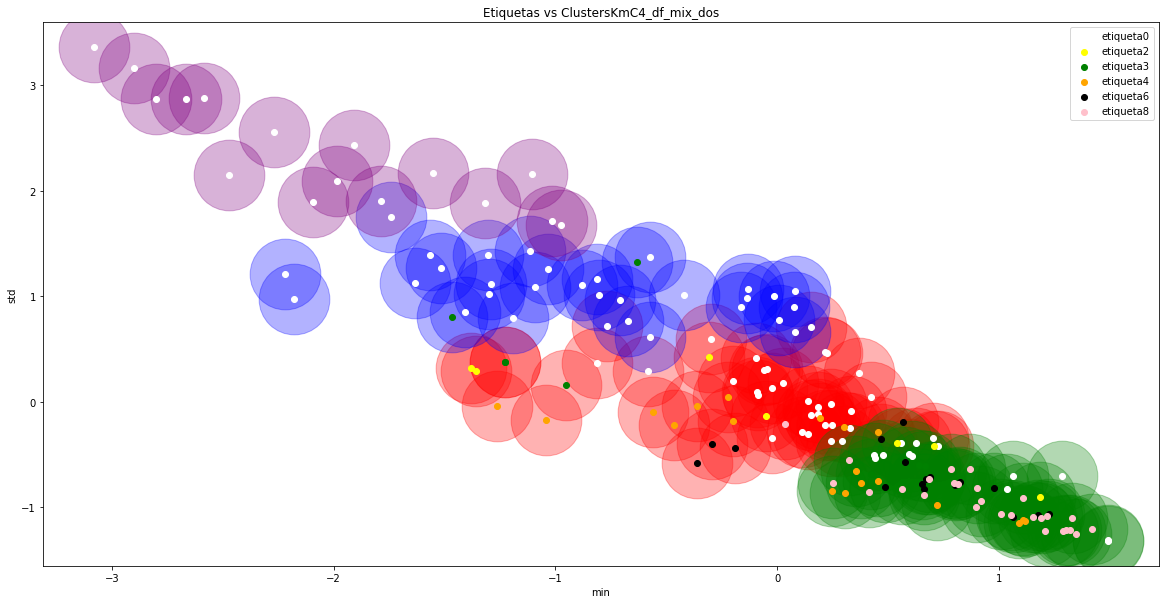

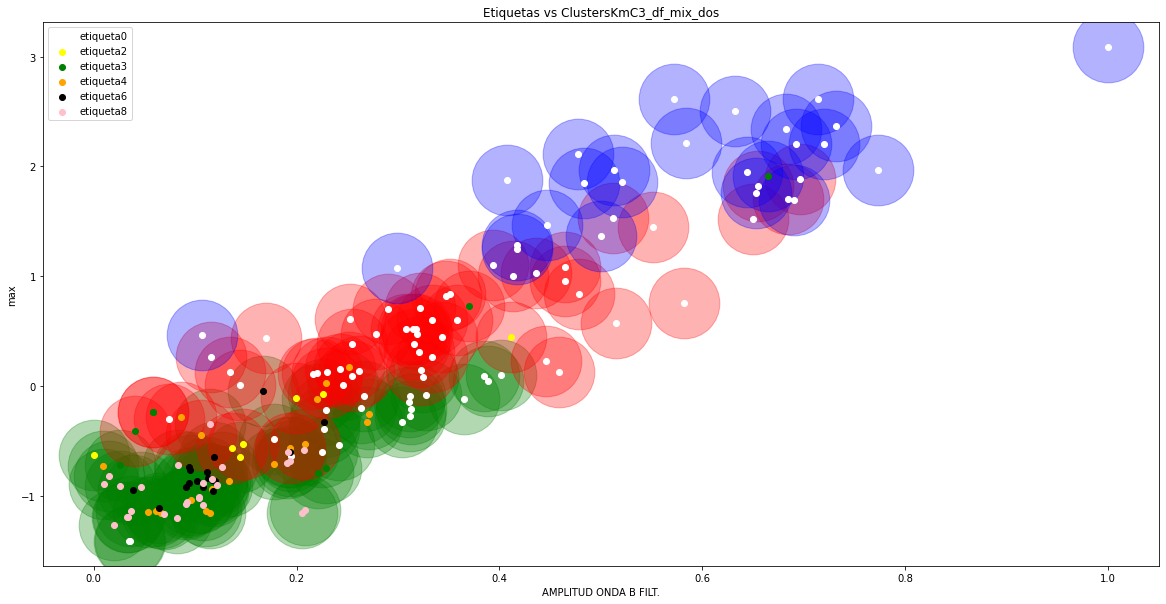

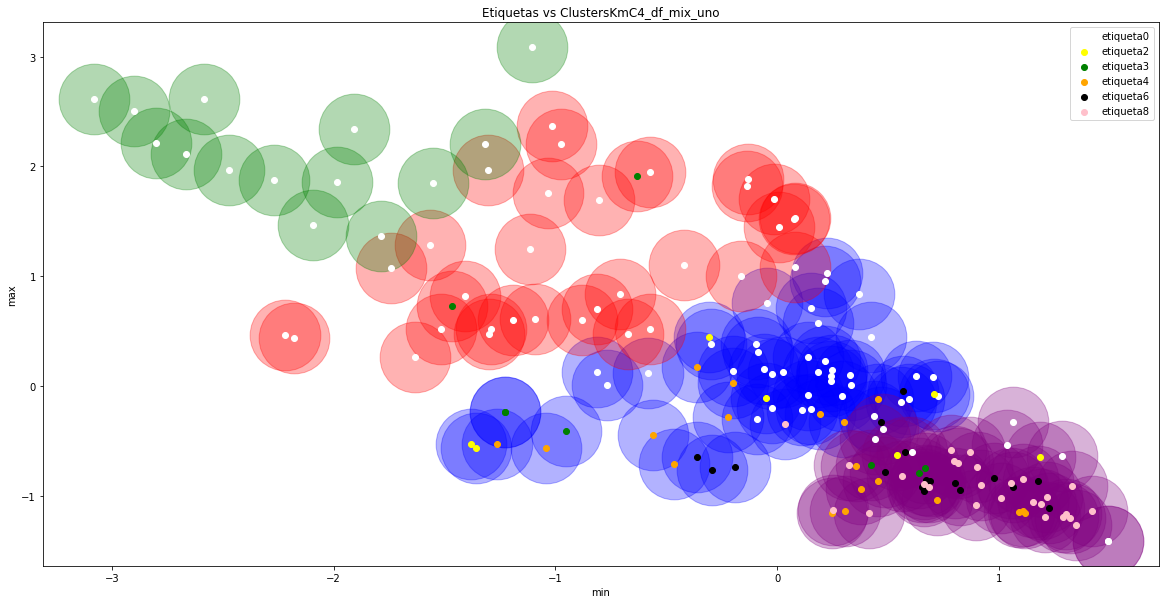

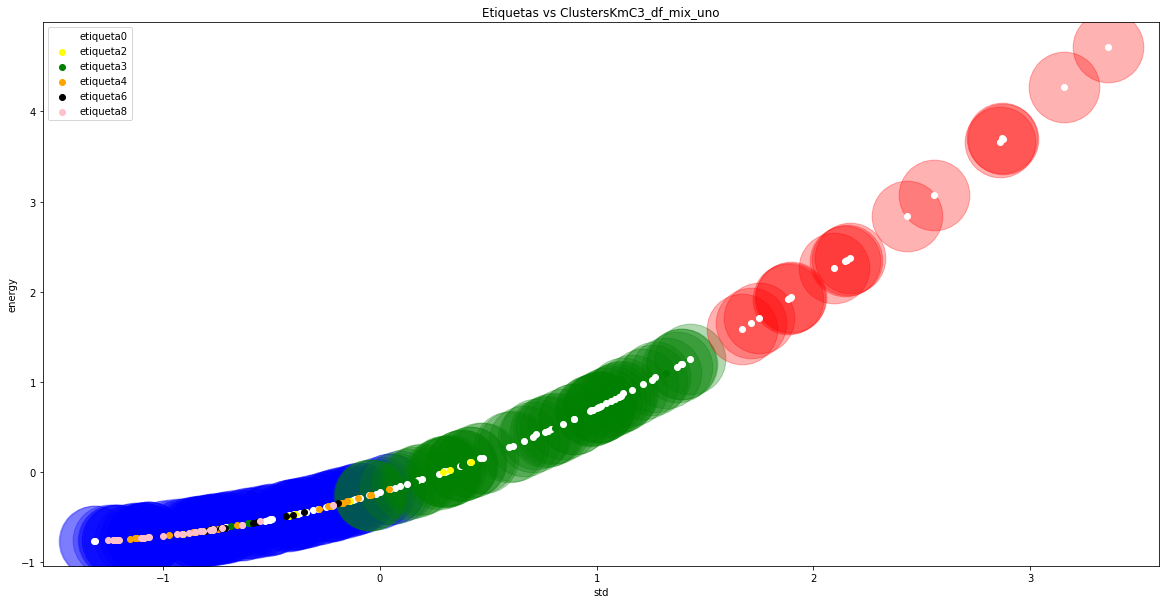

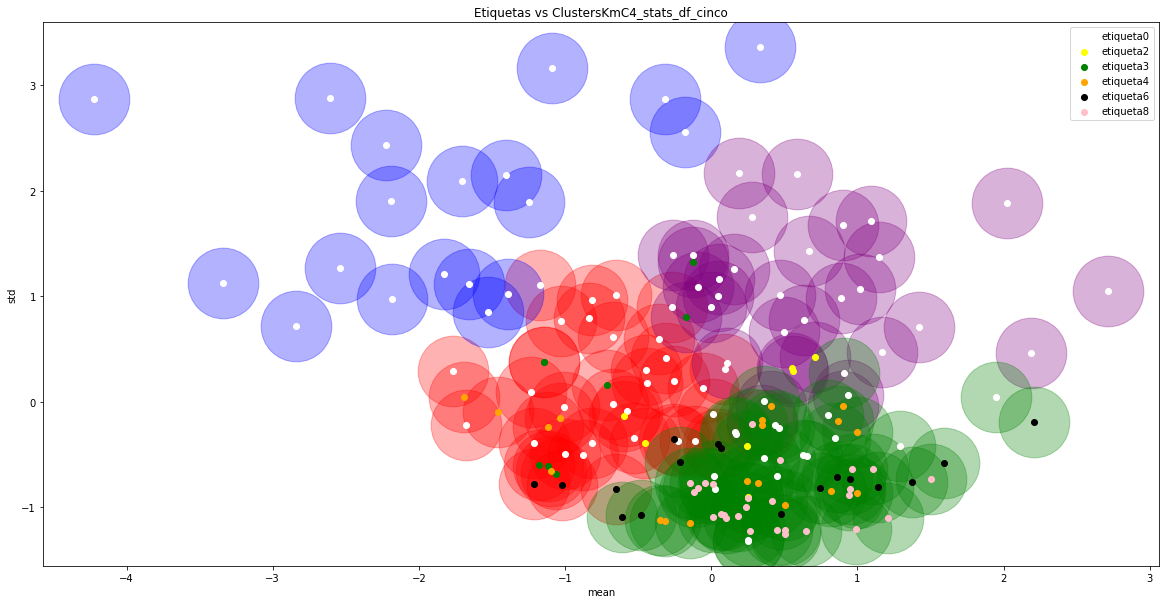

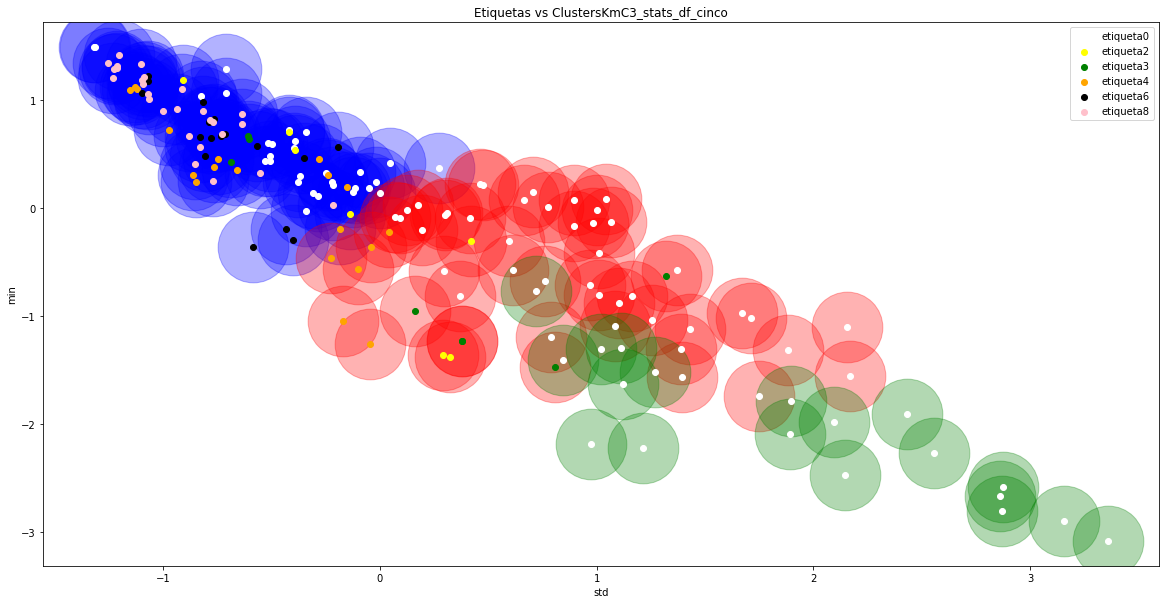

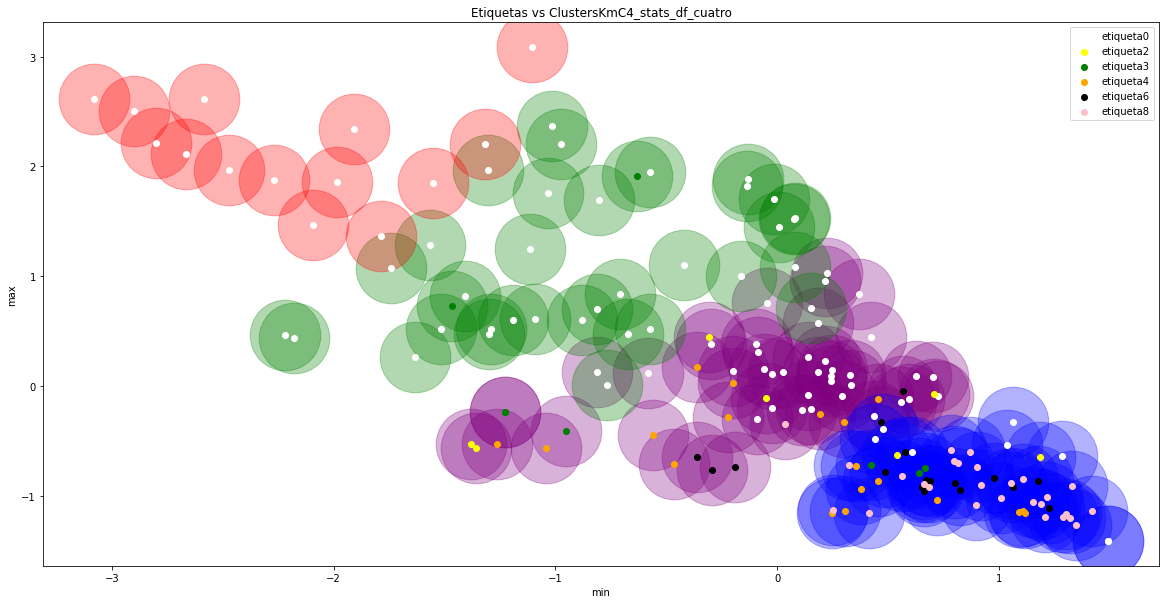

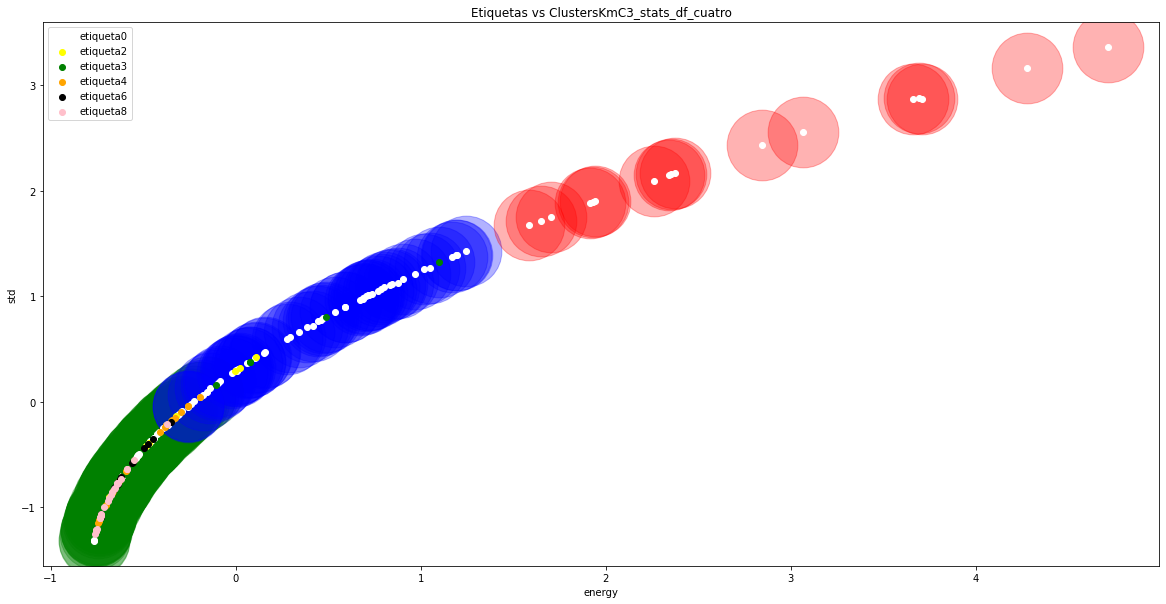

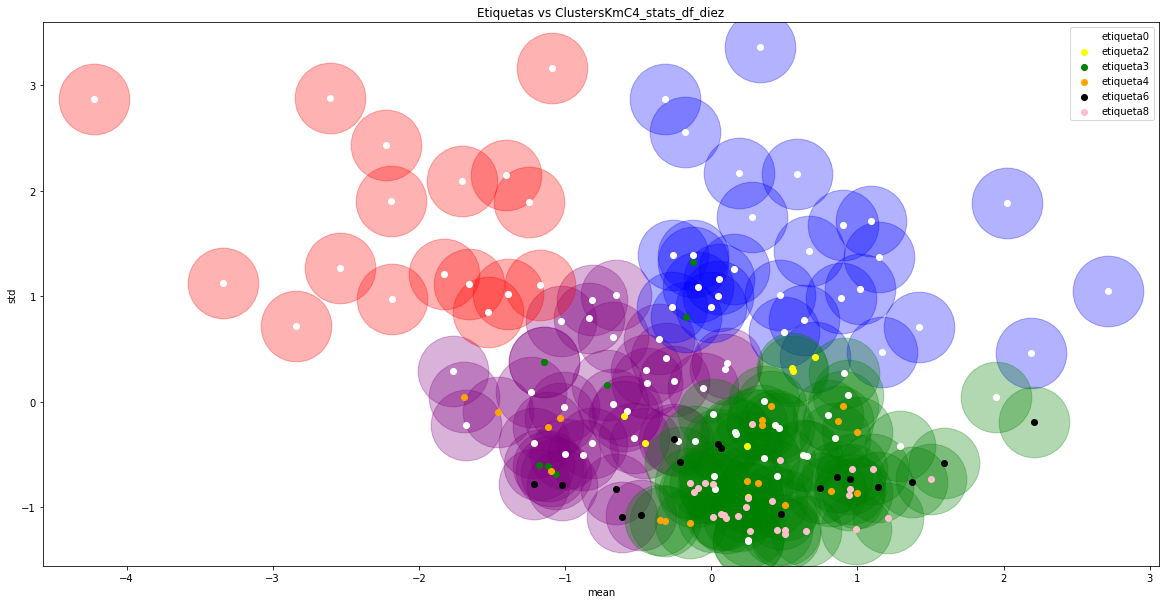

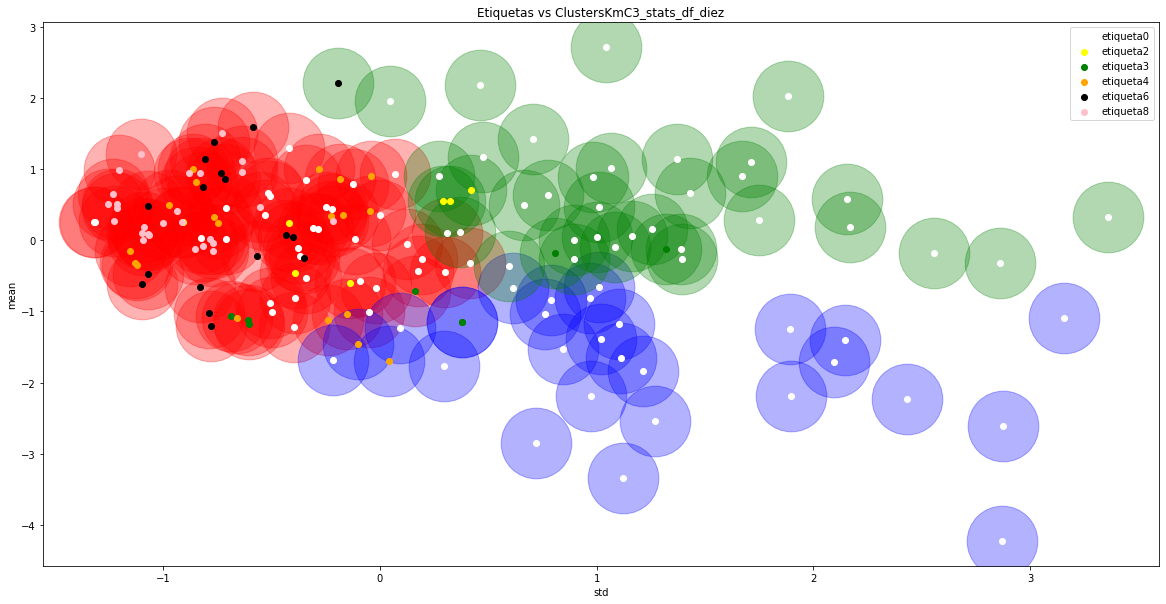

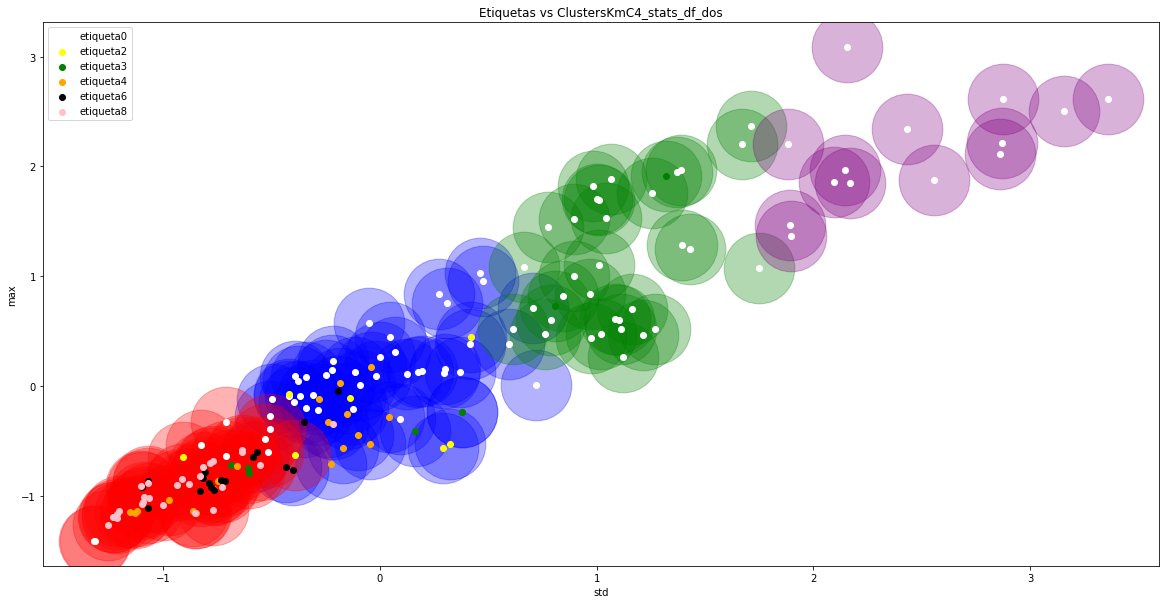

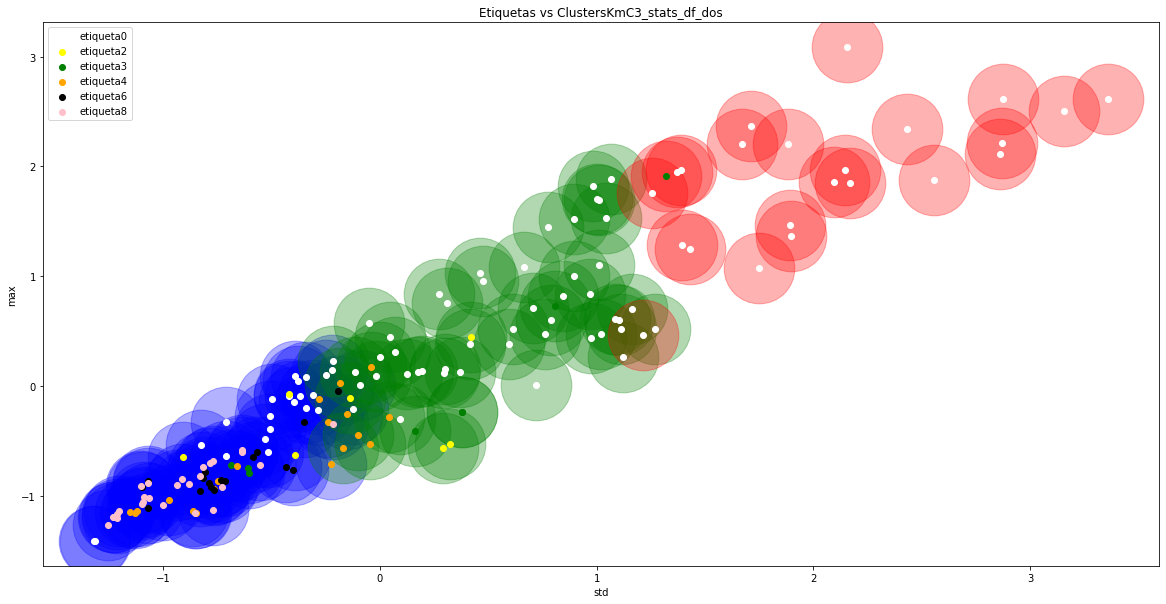

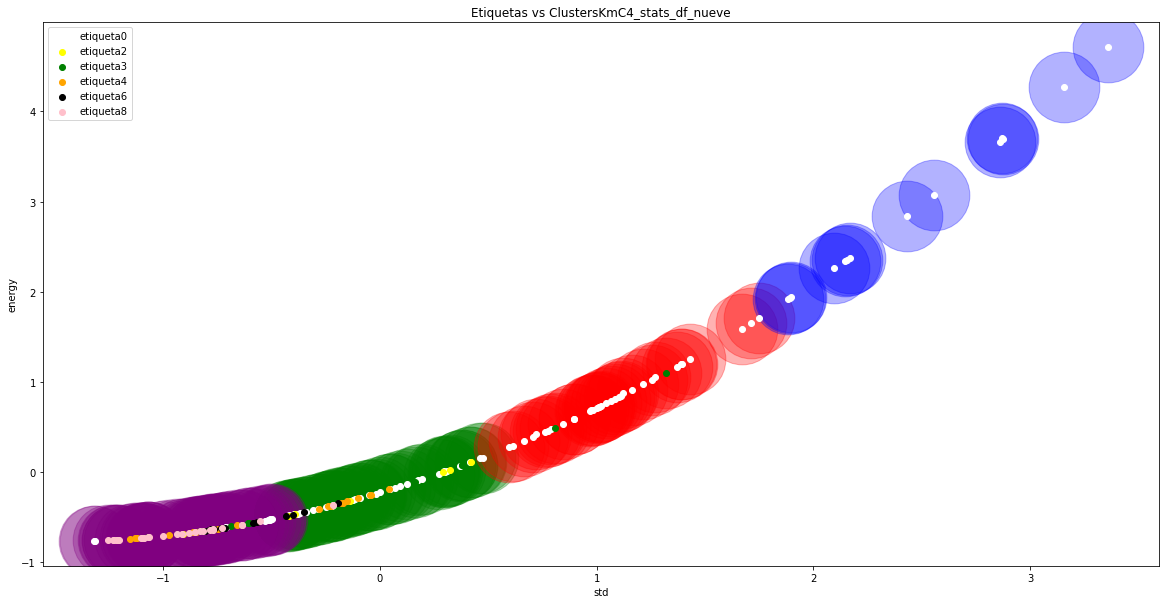

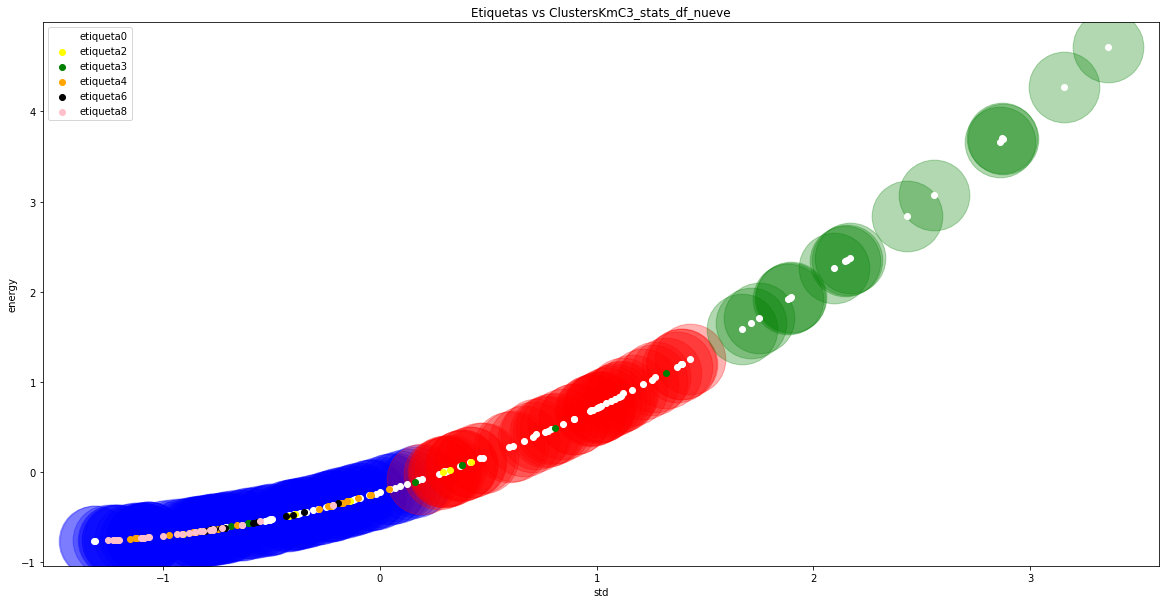

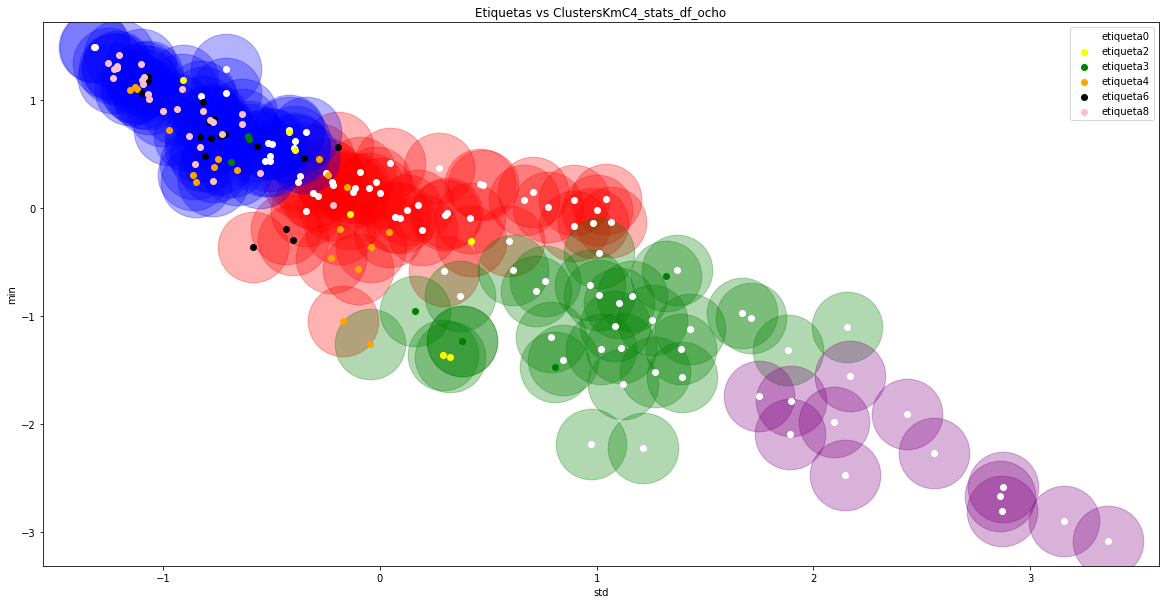

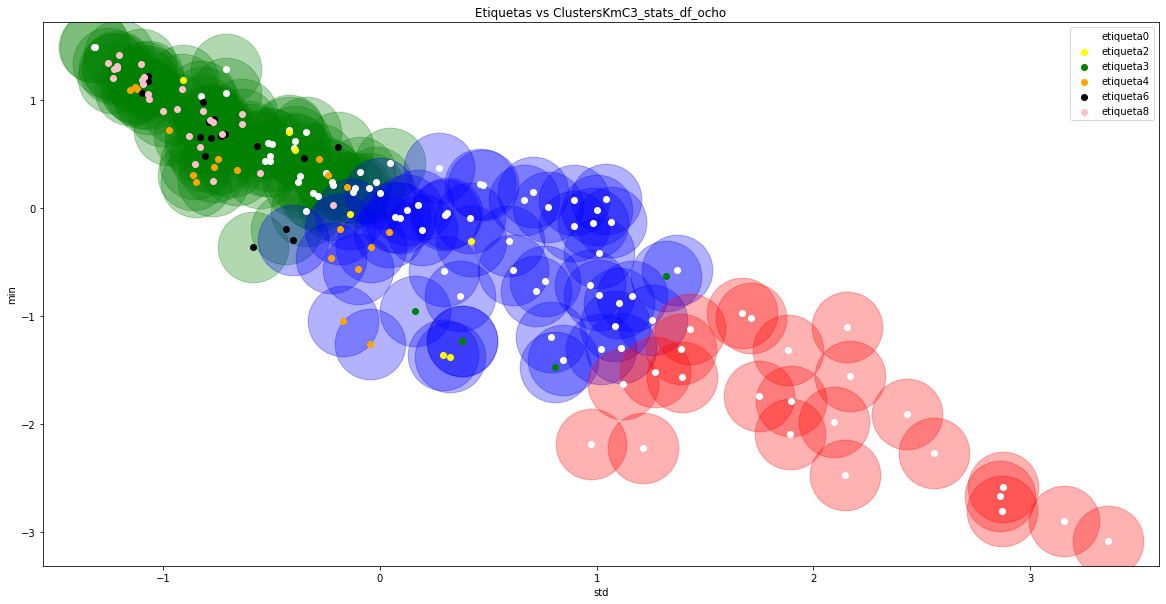

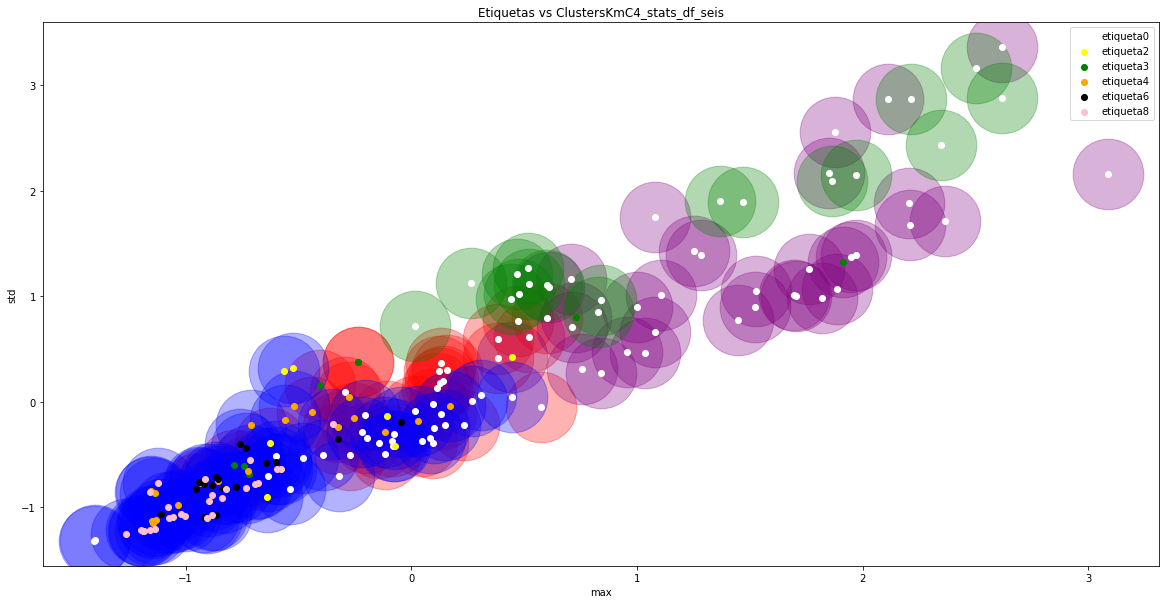

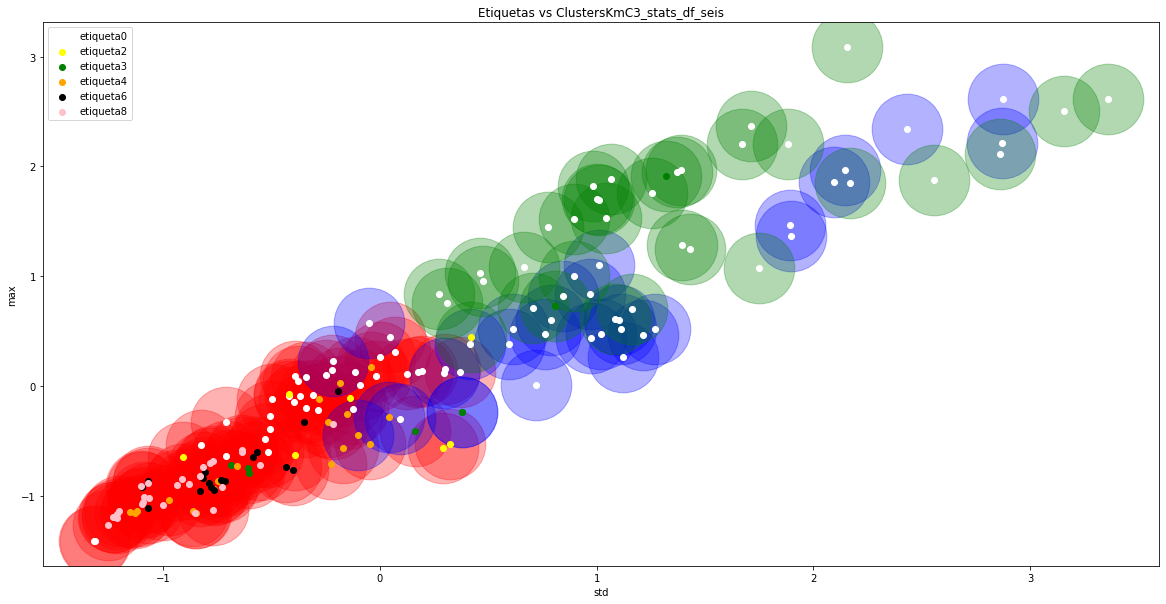

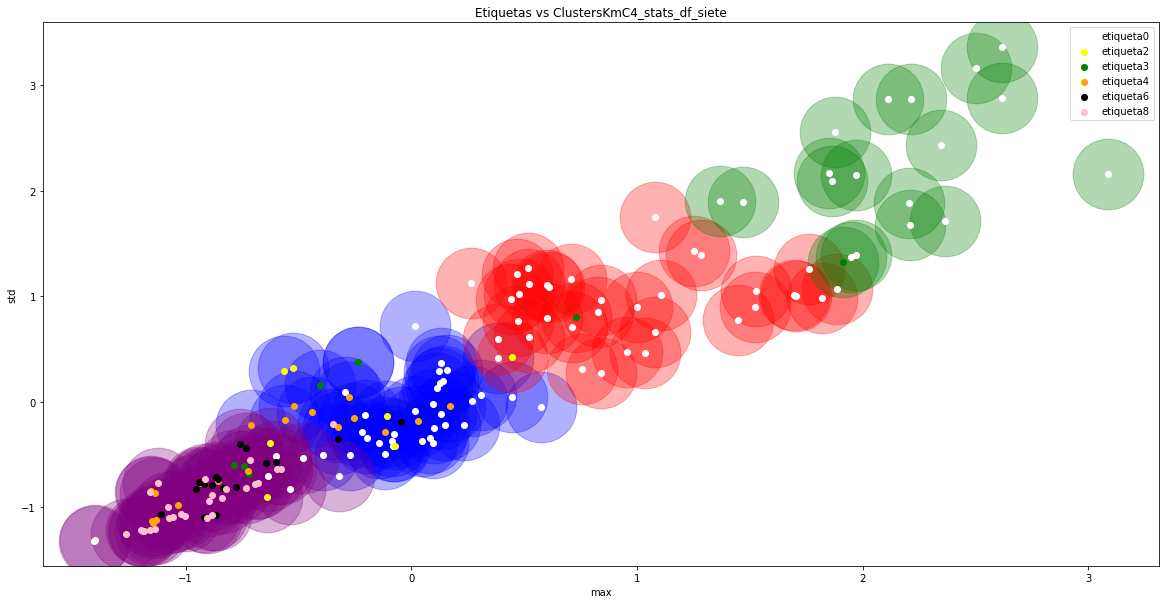

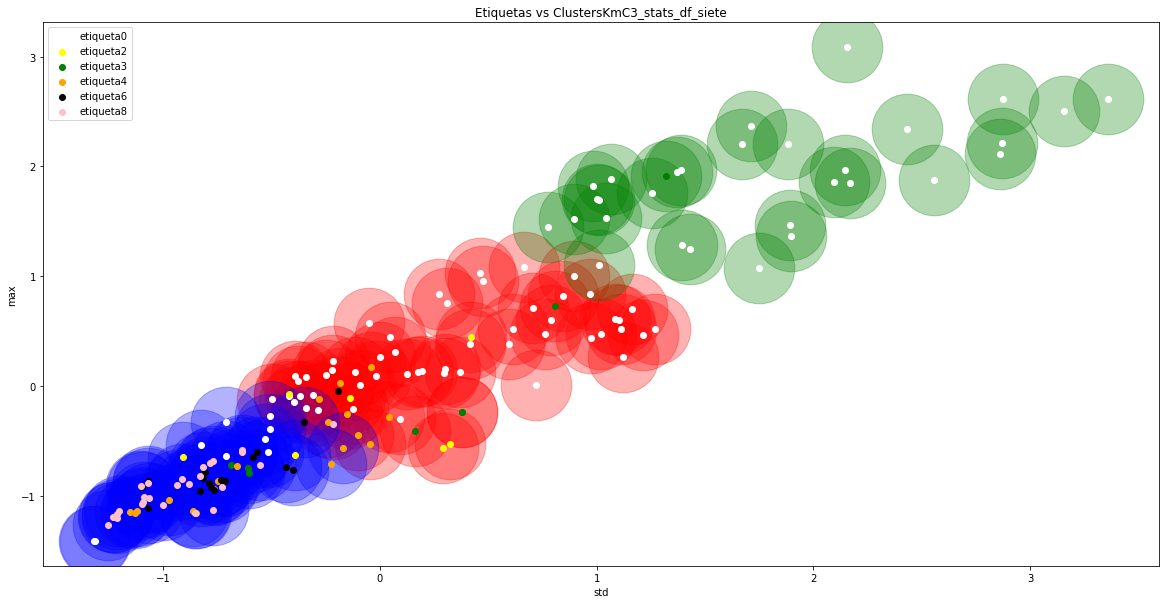

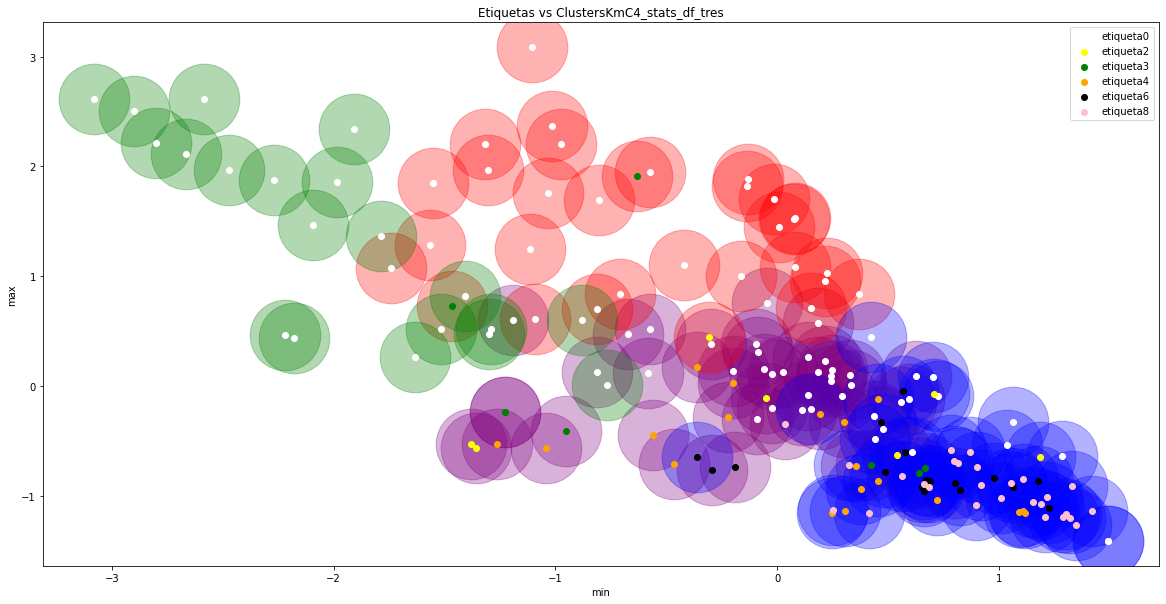

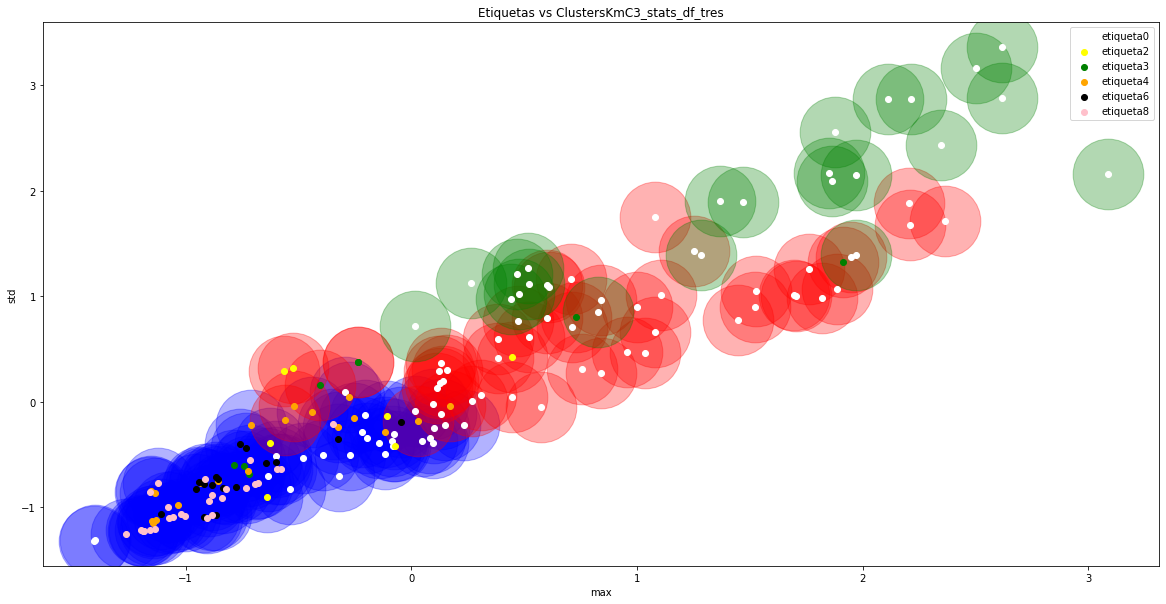

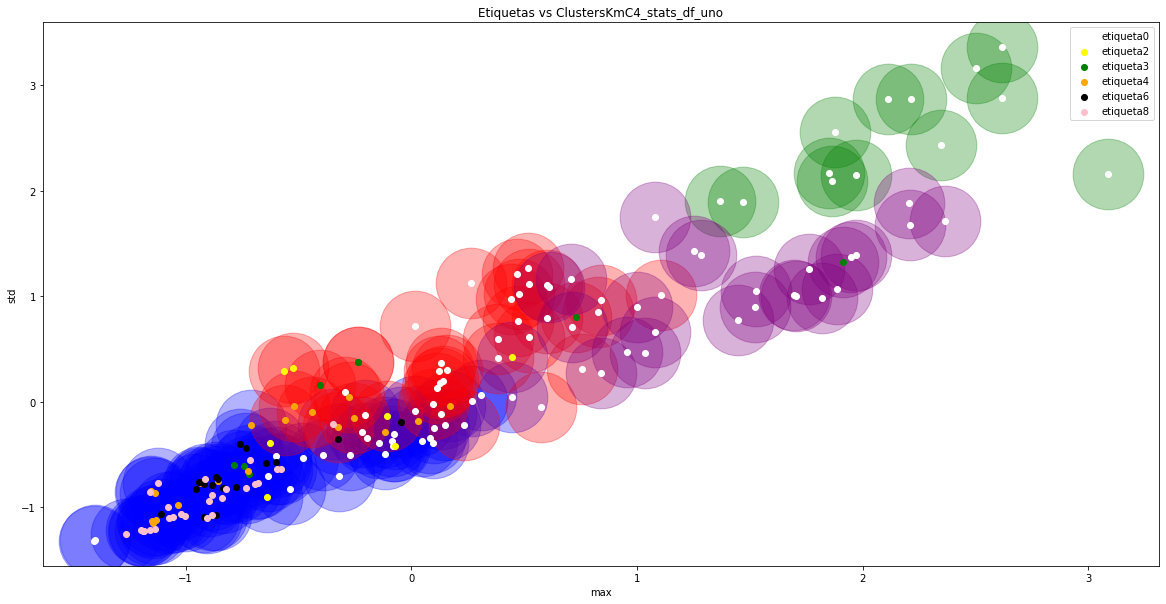

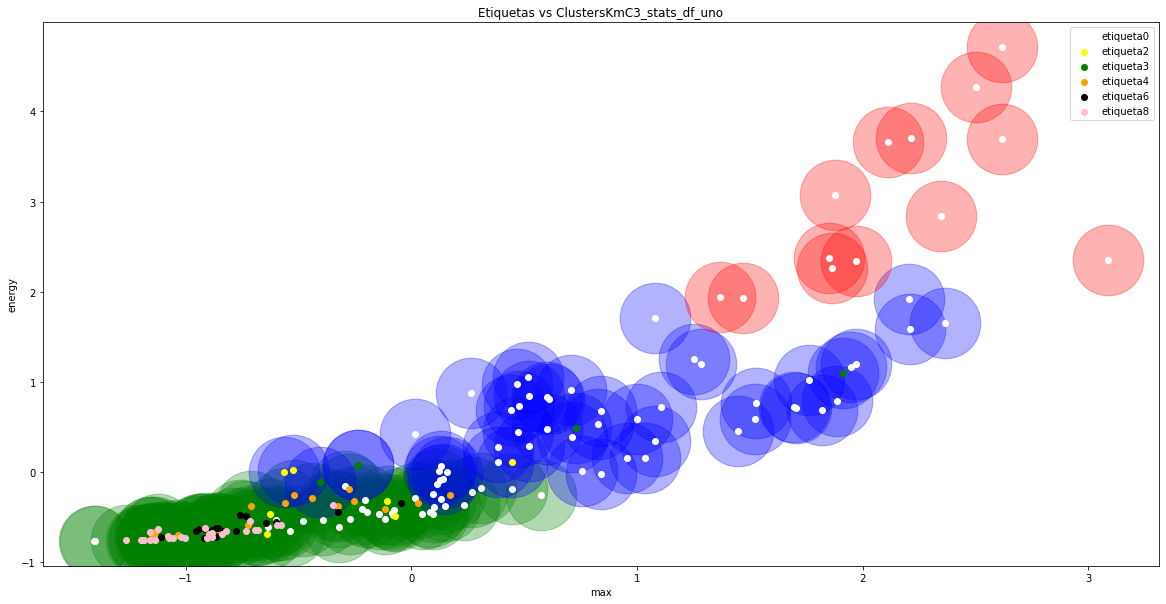

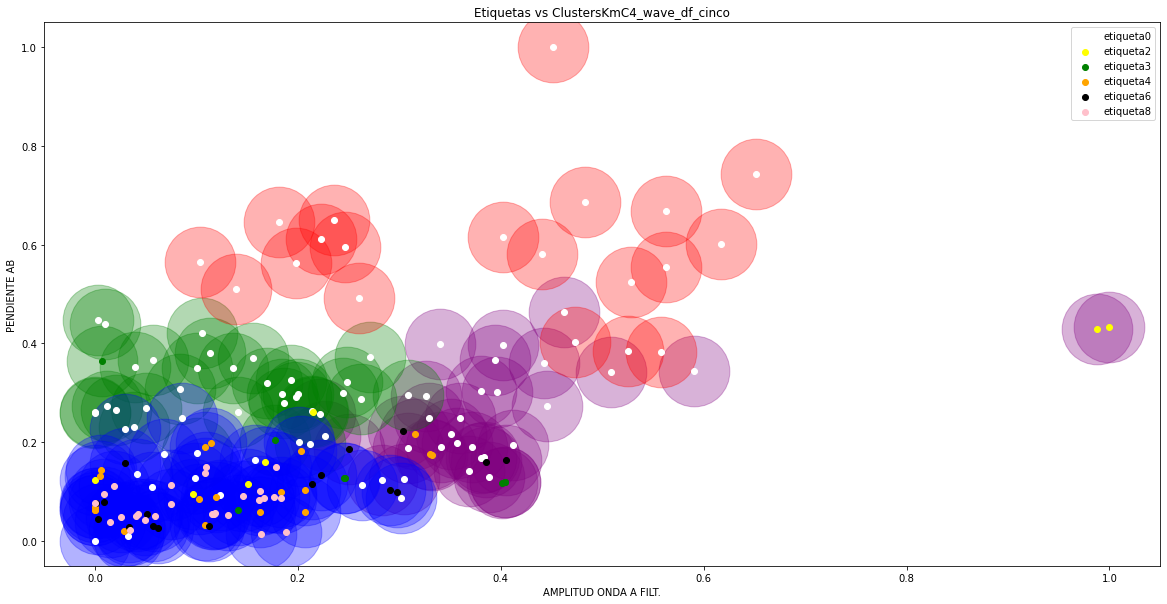

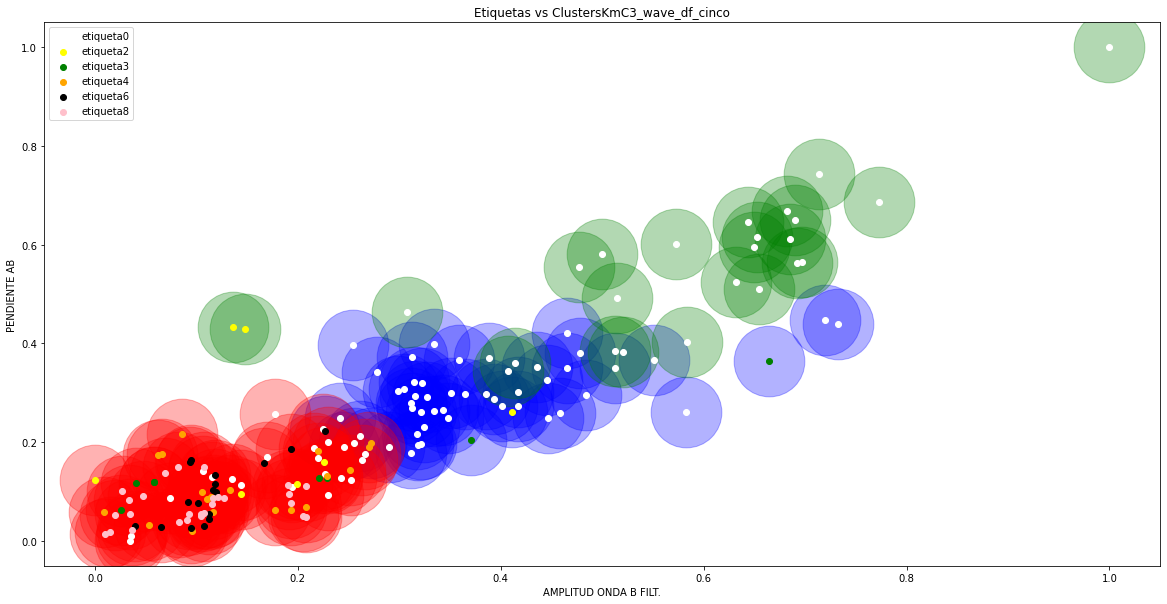

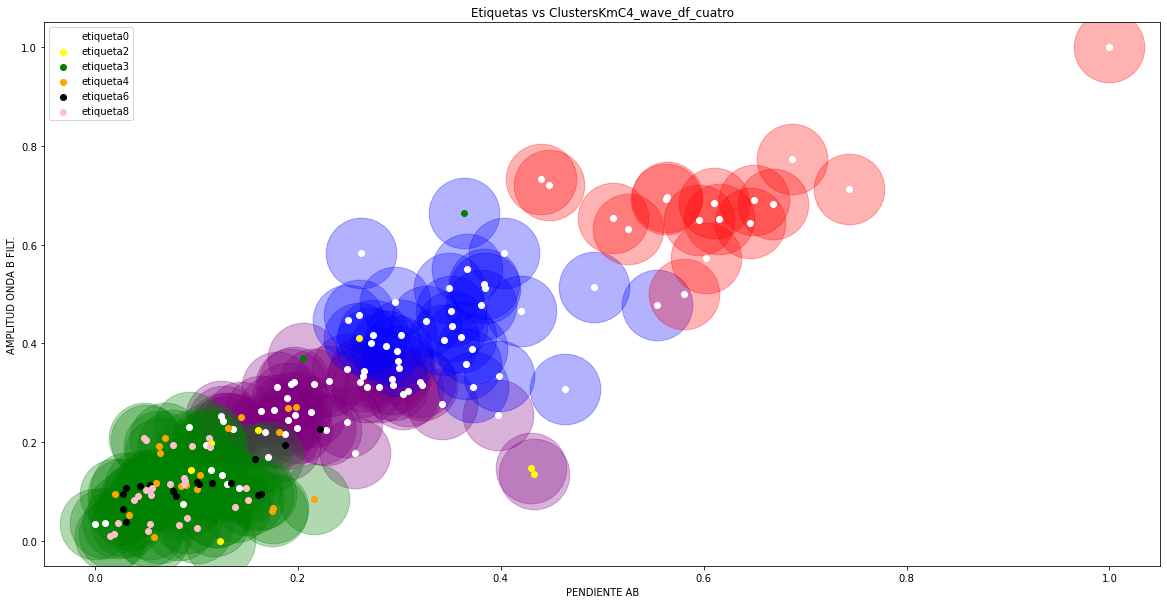

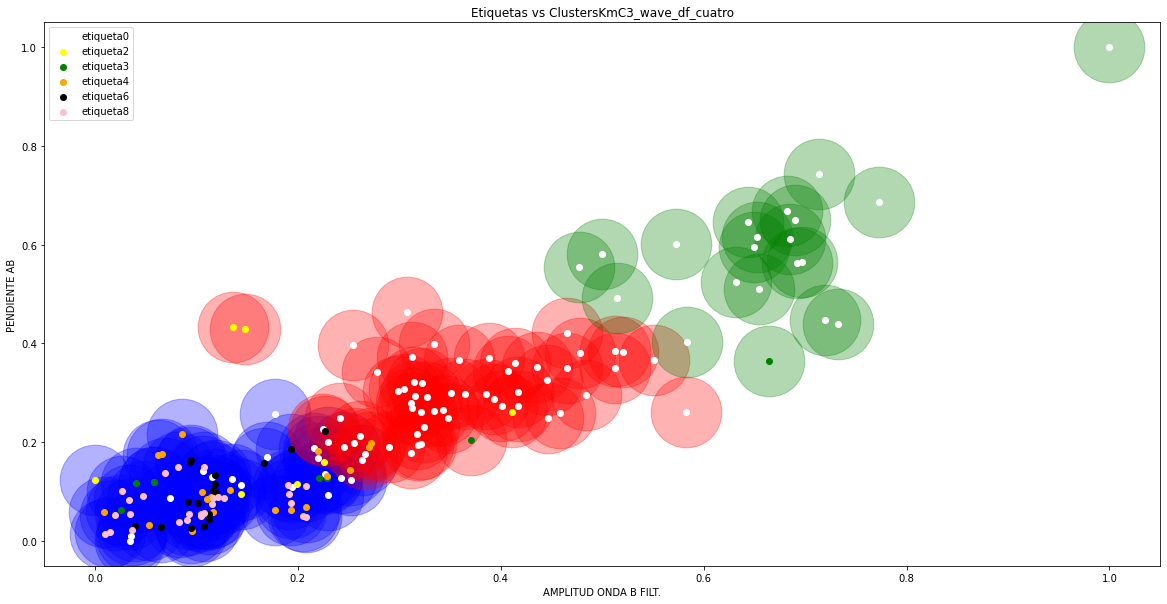

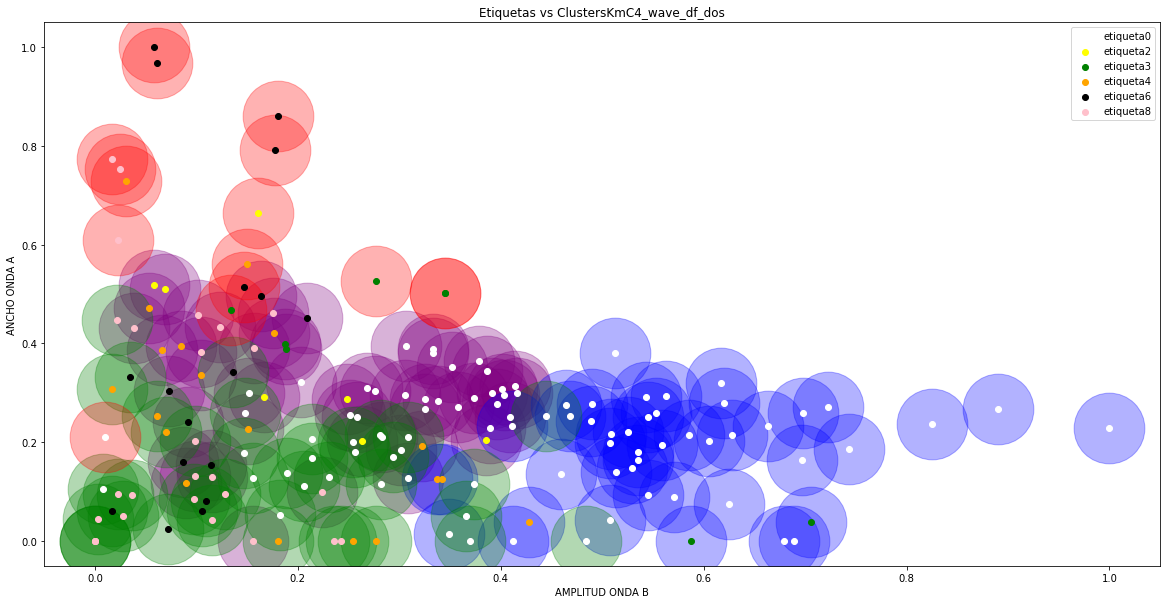

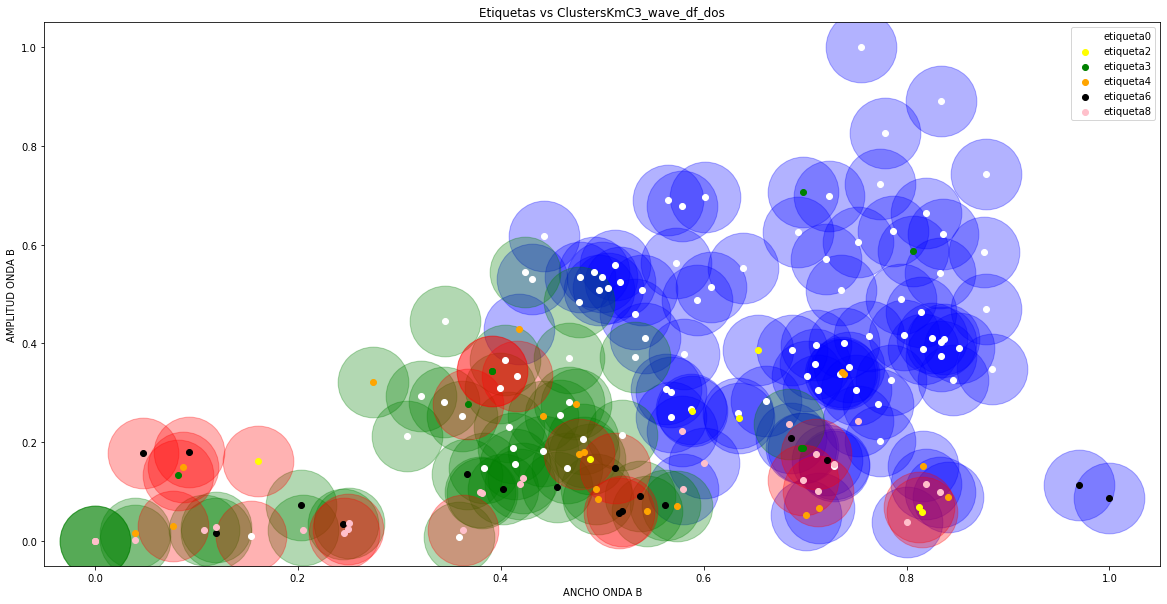

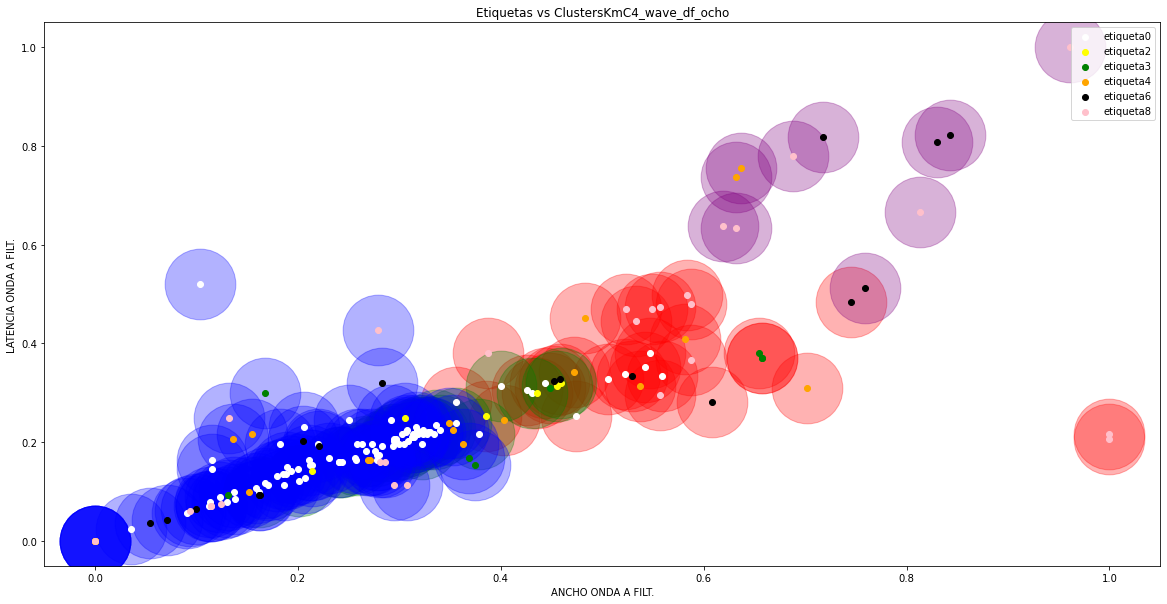

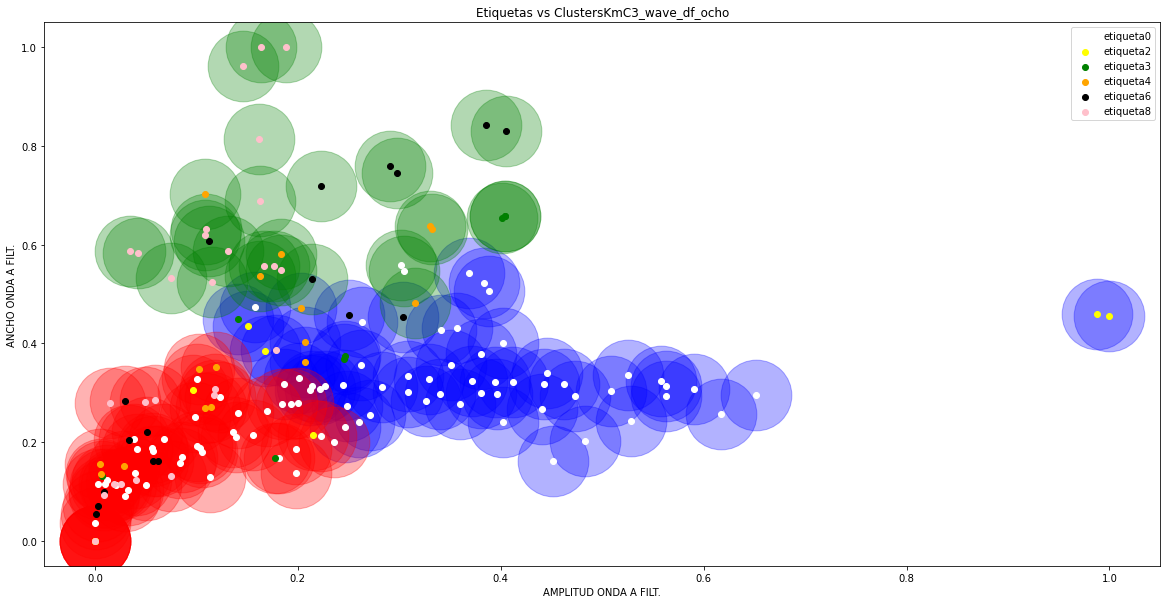

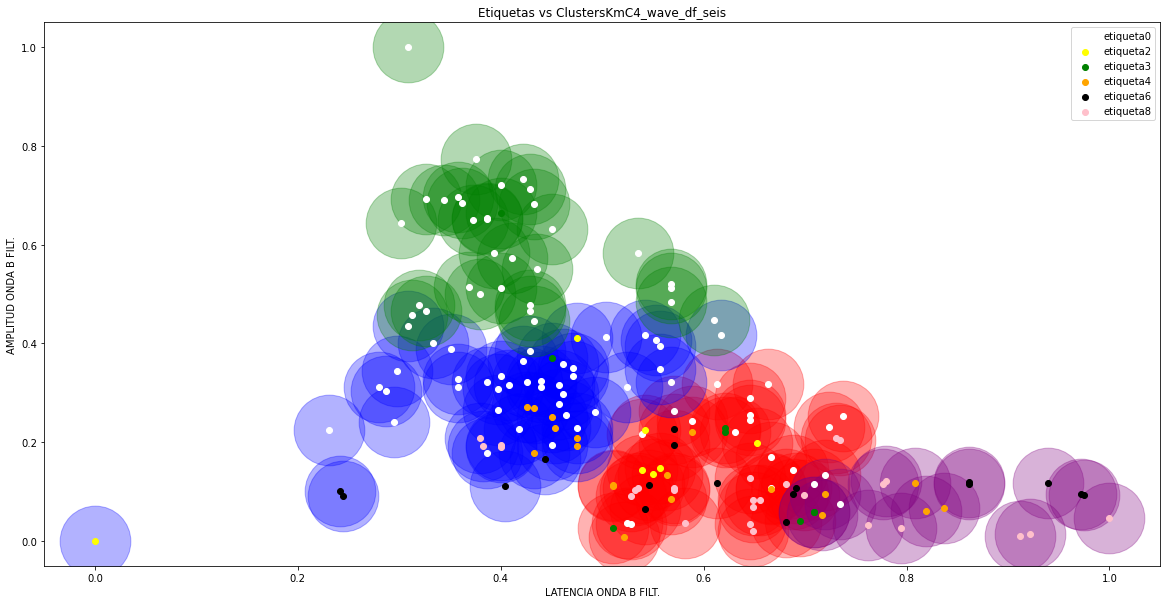

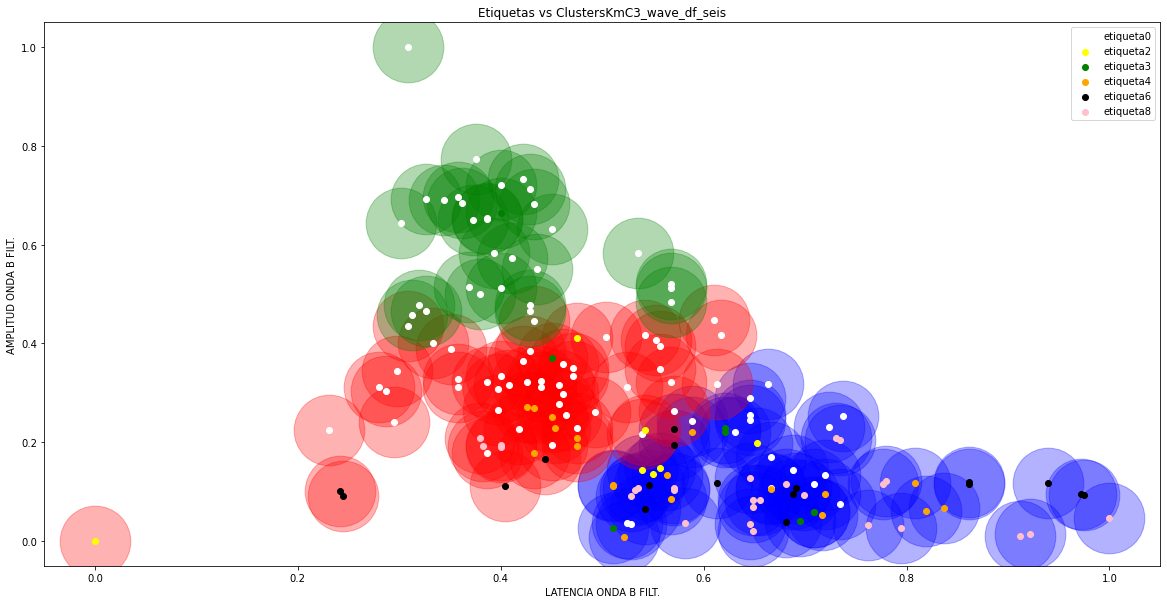

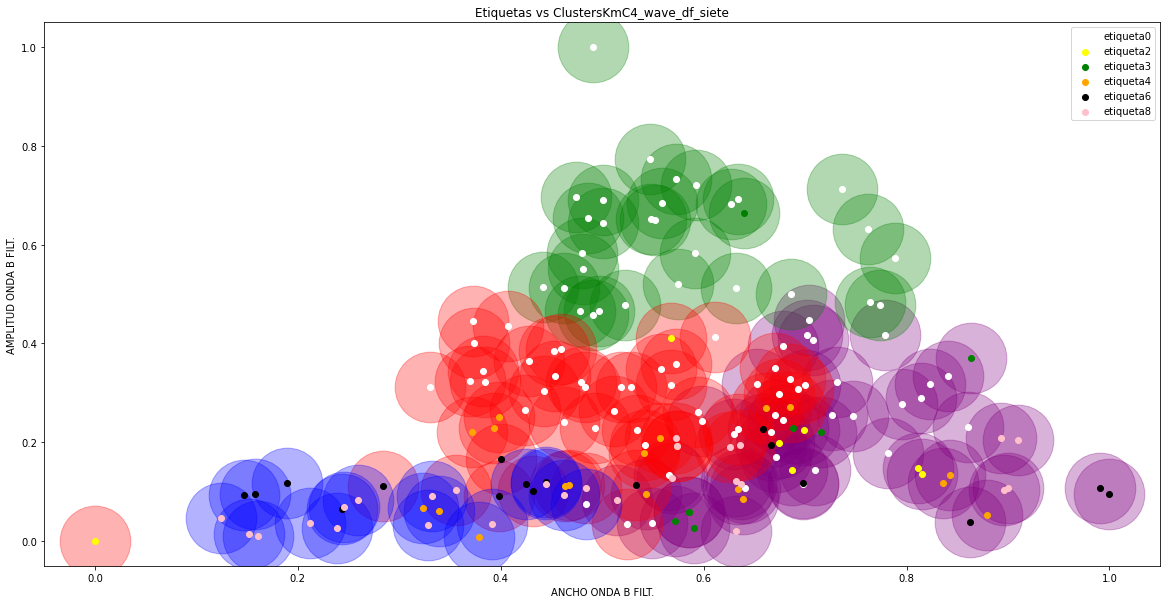

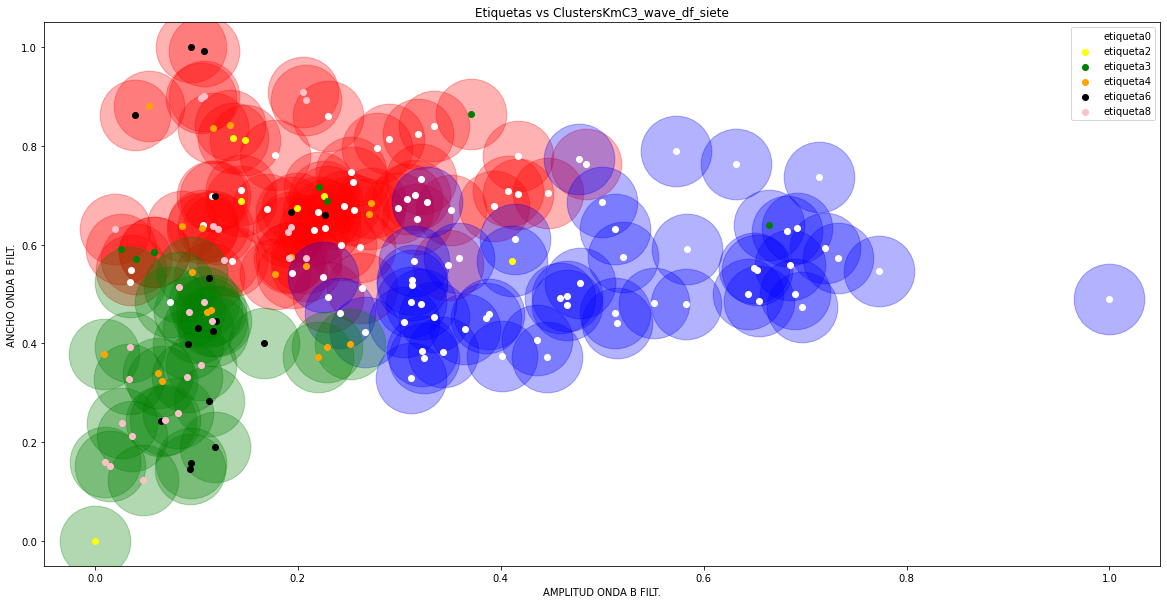

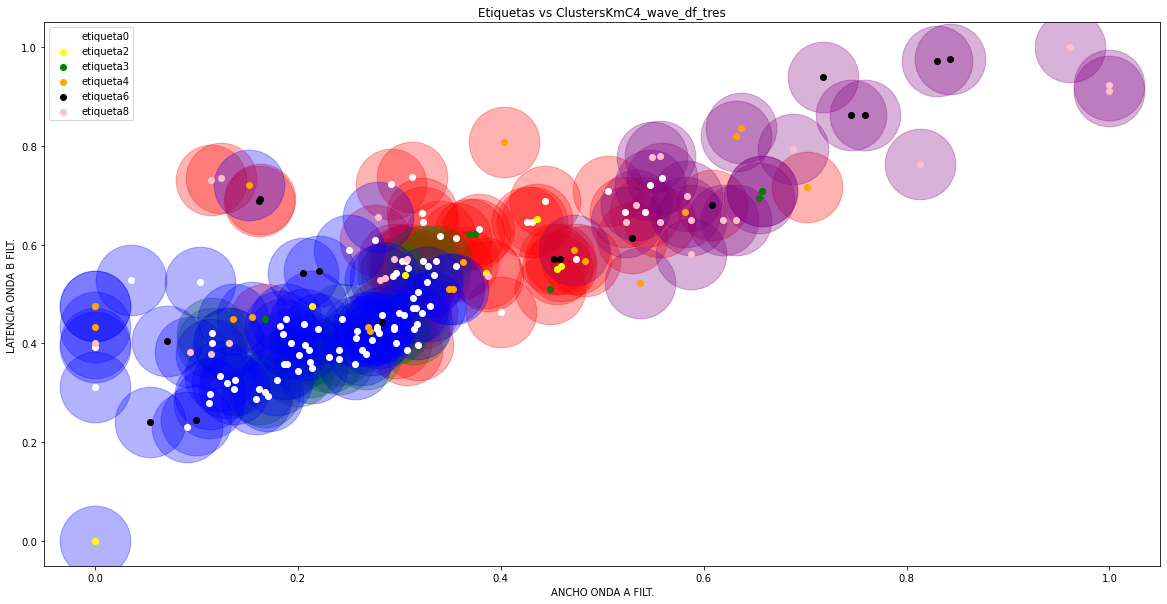

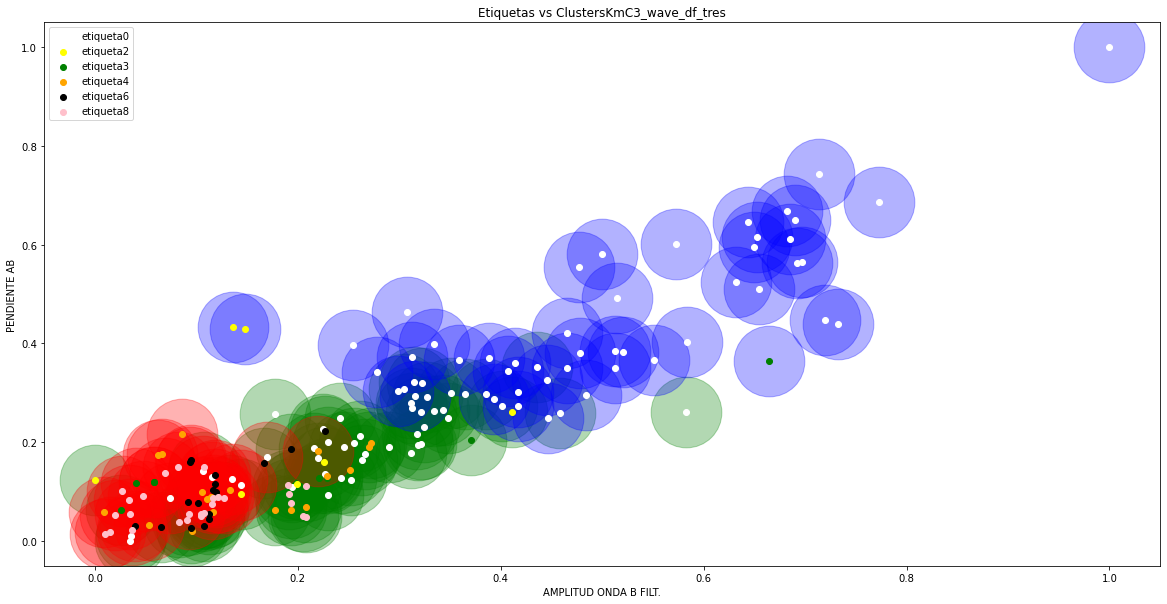

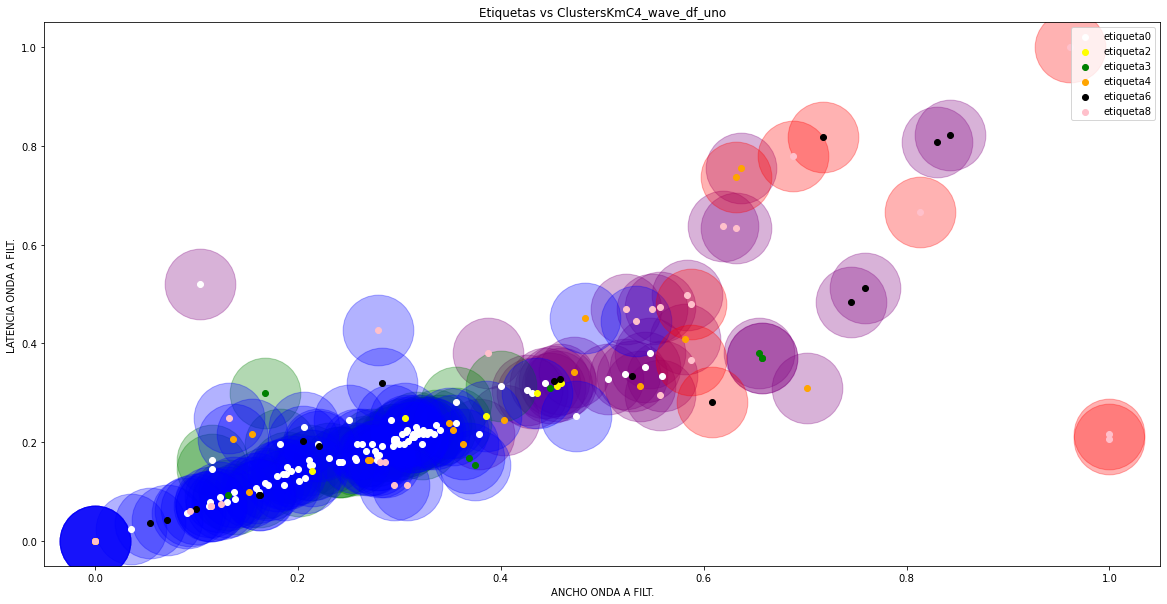

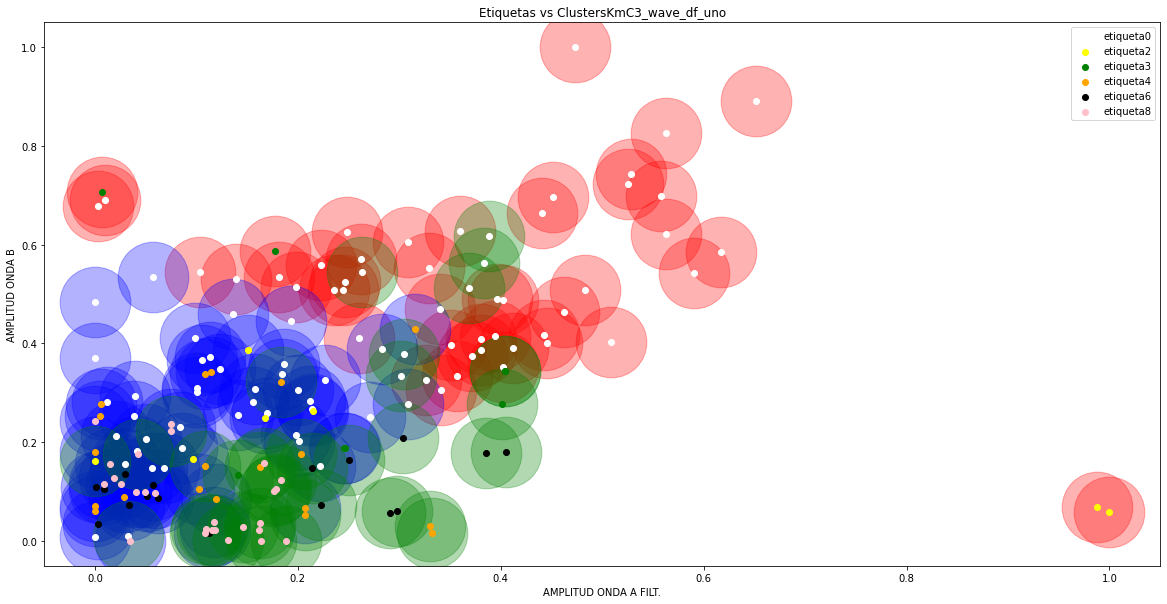

In [11]:
#dict de diccionario
model_unsupervised_dict = {"KmC4":km4,"KmC3":km3}
trained_models_unsup_dict = {}

score_unsup= pd.DataFrame()

for fila in range (len(list_df)):
    print("datarame N°:", list_df[fila][1])
    df_name=list_df[fila][1]
    df_name=df_name.split(".")[0]
    sub_dict = {} #sub dict va a llenarse de modelos entrenados 
    for model in model_unsupervised_dict.keys():
        print("model", model)
        each_df= pd.read_excel(main_path+"/"+list_df[fila][1],index_col=0)
        print(each_df)
        
        sub_dict[model] = unsupervised_training_models(each_df,score_unsup, model_unsupervised_dict[model], str(model),str(df_name))
        
        
    trained_models_unsup_dict[list_df[fila][1]] = sub_dict

        

datarame N°: df_mix_dos.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.818182  0.964286  0.885246  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.250000  0.500000  0.333333   2.000000
4              0.000000  0.000000  0.000000   6.000000
6              0.750000  0.600000  0.666667   5.000000
8              0.555556  0.625000  0.588235   8.000000
accuracy       0.705882  0.705882  0.705882   0.705882
macro avg      0.395623  0.448214  0.412247  51.000000
weighted avg   0.619677  0.705882  0.656721  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


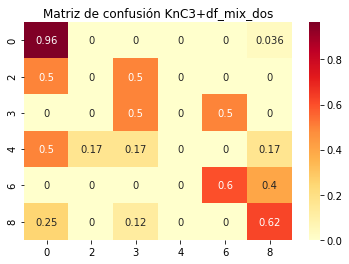

model scvL
              precision    recall  f1-score    support
0              1.000000  0.821429  0.901961  28.000000
2              0.666667  1.000000  0.800000   2.000000
3              0.166667  0.500000  0.250000   2.000000
4              0.428571  0.500000  0.461538   6.000000
6              0.333333  0.400000  0.363636   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.515873  0.599405  0.534285  51.000000
weighted avg   0.743231  0.666667  0.693547  51.000000


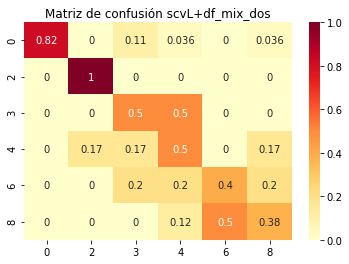

model RF
              precision    recall  f1-score    support
0              0.848485  1.000000  0.918033  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  1.000000  1.000000   2.000000
4              0.666667  0.333333  0.444444   6.000000
6              0.666667  0.800000  0.727273   5.000000
8              0.666667  0.500000  0.571429   8.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.808081  0.688889  0.721308  51.000000
weighted avg   0.792632  0.803922  0.782602  51.000000


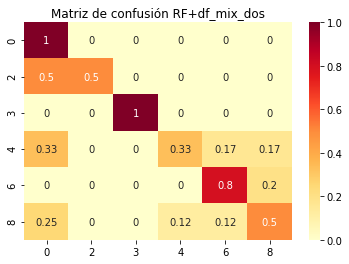

datarame N°: df_mix_uno.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.900000  0.964286  0.931034  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.250000  0.500000  0.333333   2.000000
4              1.000000  0.333333  0.500000   6.000000
6              0.666667  0.800000  0.727273   5.000000
8              0.714286  0.625000  0.666667   8.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.588492  0.537103  0.526385  51.000000
weighted avg   0.798973  0.764706  0.758928  51.000000


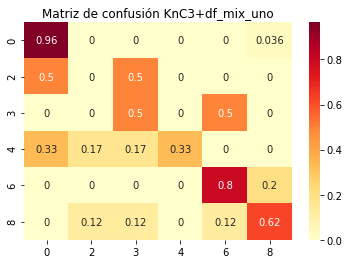

model scvL
              precision    recall  f1-score    support
0              0.958333  0.821429  0.884615  28.000000
2              0.500000  0.500000  0.500000   2.000000
3              0.250000  0.500000  0.333333   2.000000
4              0.500000  0.500000  0.500000   6.000000
6              0.285714  0.400000  0.333333   5.000000
8              0.500000  0.500000  0.500000   8.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.499008  0.536905  0.508547  51.000000
weighted avg   0.720822  0.666667  0.688286  51.000000


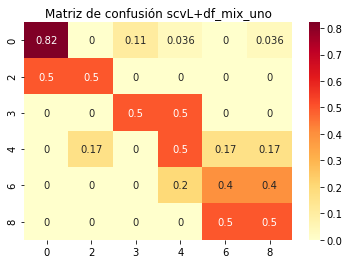

model RF
              precision    recall  f1-score    support
0              0.875000  1.000000  0.933333  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  1.000000  1.000000   2.000000
4              0.800000  0.666667  0.727273   6.000000
6              0.666667  0.800000  0.727273   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.843137  0.843137  0.843137   0.843137
macro avg      0.856944  0.744444  0.778322  51.000000
weighted avg   0.843791  0.843137  0.831171  51.000000


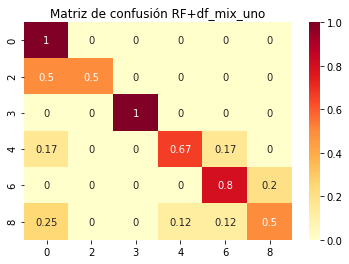

datarame N°: stats_df_cinco.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.722222  0.928571  0.812500  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.333333  0.500000  0.400000   2.000000
4              0.500000  0.166667  0.250000   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.625000  0.625000  0.625000   8.000000
accuracy       0.647059  0.647059  0.647059   0.647059
macro avg      0.363426  0.370040  0.347917  51.000000
weighted avg   0.566449  0.647059  0.589216  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


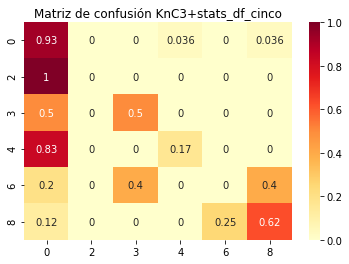

model scvL
              precision    recall  f1-score    support
0              1.000000  0.785714  0.880000  28.000000
2              0.500000  1.000000  0.666667   2.000000
3              0.222222  1.000000  0.363636   2.000000
4              0.500000  0.333333  0.400000   6.000000
6              0.166667  0.200000  0.181818   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.627451  0.627451  0.627451   0.627451
macro avg      0.481481  0.615675  0.486782  51.000000
weighted avg   0.730937  0.627451  0.655652  51.000000


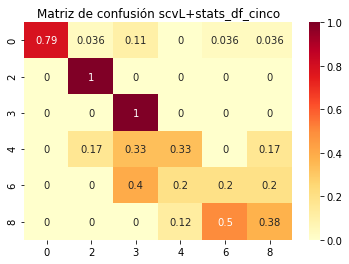

model RF
              precision    recall  f1-score    support
0              0.875000  1.000000  0.933333  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  1.000000  1.000000   2.000000
4              1.000000  0.500000  0.666667   6.000000
6              0.571429  0.800000  0.666667   5.000000
8              0.666667  0.500000  0.571429   8.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.852183  0.716667  0.750794  51.000000
weighted avg   0.837068  0.823529  0.811204  51.000000


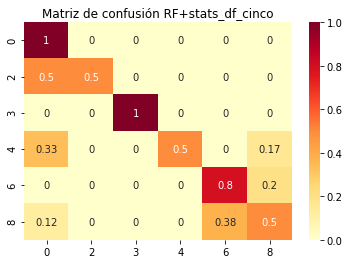

datarame N°: stats_df_cuatro.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.843750  0.964286  0.900000  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              1.000000  0.500000  0.666667   6.000000
6              0.666667  0.800000  0.727273   5.000000
8              0.714286  0.625000  0.666667   8.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.620784  0.564881  0.576768  51.000000
weighted avg   0.777894  0.784314  0.768033  51.000000


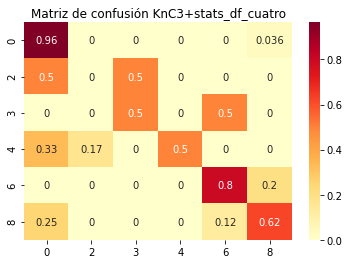

model scvL
              precision    recall  f1-score    support
0              1.000000  0.750000  0.857143  28.000000
2              0.142857  0.500000  0.222222   2.000000
3              0.250000  0.500000  0.333333   2.000000
4              0.500000  0.333333  0.400000   6.000000
6              0.222222  0.400000  0.285714   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.588235  0.588235  0.588235   0.588235
macro avg      0.435847  0.476389  0.421164  51.000000
weighted avg   0.723467  0.588235  0.634672  51.000000


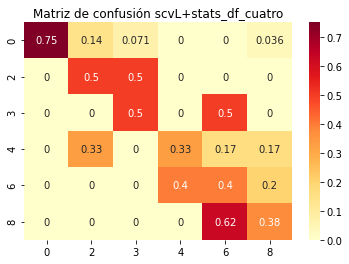

model RF
              precision    recall  f1-score    support
0              0.843750  0.964286  0.900000  28.000000
2              0.500000  0.500000  0.500000   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              1.000000  0.333333  0.500000   6.000000
6              0.500000  0.800000  0.615385   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.690625  0.599603  0.605128  51.000000
weighted avg   0.794608  0.764706  0.749020  51.000000


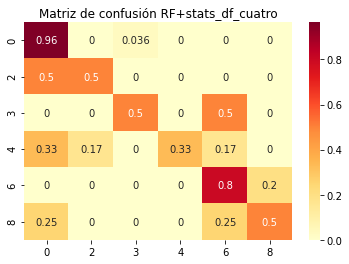

datarame N°: stats_df_diez.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.750000  0.857143  0.800000  28.000000
2              0.250000  0.500000  0.333333   2.000000
3              0.333333  0.500000  0.400000   2.000000
4              0.400000  0.333333  0.363636   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.500000  0.250000  0.333333   8.000000
accuracy       0.588235  0.588235  0.588235   0.588235
macro avg      0.372222  0.406746  0.371717  51.000000
weighted avg   0.560131  0.588235  0.563042  51.000000


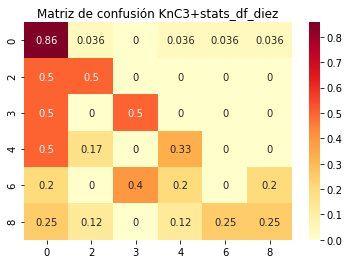

model scvL
              precision    recall  f1-score    support
0              0.928571  0.464286  0.619048  28.000000
2              0.166667  0.500000  0.250000   2.000000
3              0.133333  1.000000  0.235294   2.000000
4              0.000000  0.000000  0.000000   6.000000
6              0.142857  0.200000  0.166667   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.392157  0.392157  0.392157   0.392157
macro avg      0.311905  0.423214  0.283263  51.000000
weighted avg   0.614006  0.392157  0.442467  51.000000


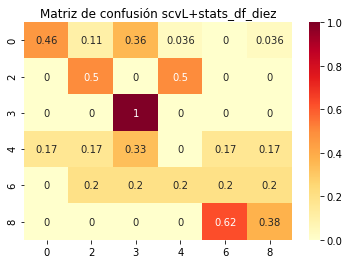

model RF
              precision    recall  f1-score   support
0              0.764706  0.928571  0.838710  28.00000
2              0.500000  0.500000  0.500000   2.00000
3              0.666667  1.000000  0.800000   2.00000
4              1.000000  0.333333  0.500000   6.00000
6              0.400000  0.400000  0.400000   5.00000
8              0.800000  0.500000  0.615385   8.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.688562  0.610317  0.609016  51.00000
weighted avg   0.747943  0.725490  0.706019  51.00000


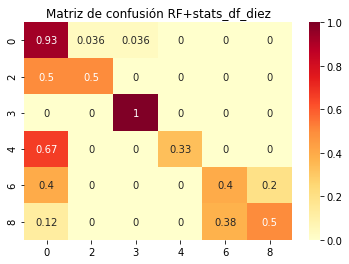

datarame N°: stats_df_dos.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.843750  0.964286  0.900000  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              1.000000  0.500000  0.666667   6.000000
6              0.666667  0.800000  0.727273   5.000000
8              0.714286  0.625000  0.666667   8.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.620784  0.564881  0.576768  51.000000
weighted avg   0.777894  0.784314  0.768033  51.000000


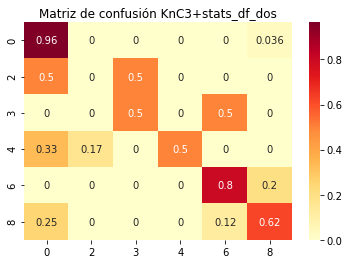

model scvL
              precision    recall  f1-score    support
0              0.923077  0.857143  0.888889  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.200000  0.500000  0.285714   2.000000
4              0.333333  0.333333  0.333333   6.000000
6              0.200000  0.200000  0.200000   5.000000
8              0.500000  0.500000  0.500000   8.000000
accuracy       0.627451  0.627451  0.627451   0.627451
macro avg      0.359402  0.398413  0.367989  51.000000
weighted avg   0.651885  0.627451  0.636477  51.000000


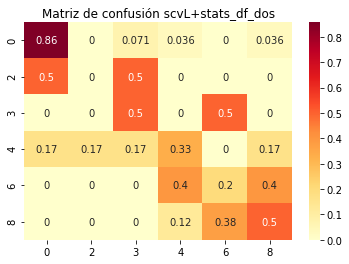

model RF
              precision    recall  f1-score    support
0              0.843750  0.964286  0.900000  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              0.750000  0.500000  0.600000   6.000000
6              0.571429  0.800000  0.666667   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.744196  0.627381  0.658120  51.000000
weighted avg   0.791807  0.784314  0.772348  51.000000


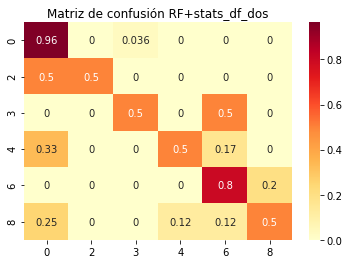

datarame N°: stats_df_nueve.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.750000  0.964286  0.843750  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.000000  0.000000  0.000000   2.000000
4              1.000000  0.333333  0.500000   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.428571  0.375000  0.400000   8.000000
accuracy       0.627451  0.627451  0.627451   0.627451
macro avg      0.363095  0.278770  0.290625  51.000000
weighted avg   0.596639  0.627451  0.584804  51.000000


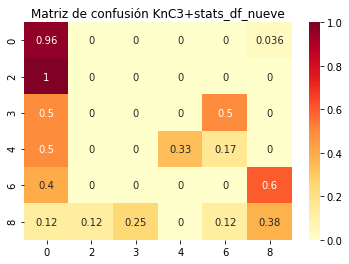

model scvL
              precision    recall  f1-score    support
0              1.000000  0.250000  0.400000  28.000000
2              0.166667  0.500000  0.250000   2.000000
3              0.000000  0.000000  0.000000   2.000000
4              0.500000  0.333333  0.400000   6.000000
6              0.285714  0.800000  0.421053   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.333333  0.333333  0.333333   0.333333
macro avg      0.408730  0.376389  0.316604  51.000000
weighted avg   0.720822  0.333333  0.384977  51.000000


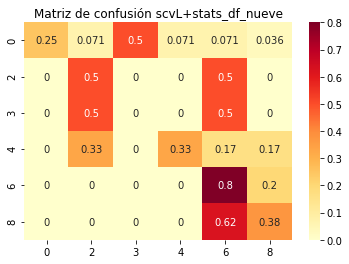

model RF


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score    support
0              0.800000  0.857143  0.827586  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.666667  1.000000  0.800000   2.000000
4              0.400000  0.333333  0.363636   6.000000
6              0.125000  0.200000  0.153846   5.000000
8              0.600000  0.375000  0.461538   8.000000
accuracy       0.627451  0.627451  0.627451   0.627451
macro avg      0.431944  0.460913  0.434435  51.000000
weighted avg   0.618791  0.627451  0.615995  51.000000


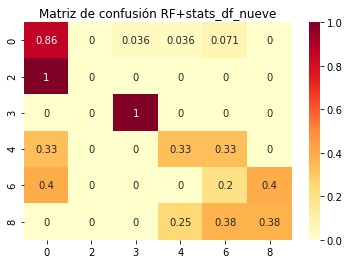

datarame N°: stats_df_ocho.xlsx
model KnC3
              precision    recall  f1-score   support
0              0.870968  0.964286  0.915254  28.00000
2              0.000000  0.000000  0.000000   2.00000
3              0.250000  0.500000  0.333333   2.00000
4              0.666667  0.333333  0.444444   6.00000
6              0.750000  0.600000  0.666667   5.00000
8              0.571429  0.500000  0.533333   8.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.518177  0.482937  0.482172  51.00000
weighted avg   0.729579  0.725490  0.716872  51.00000


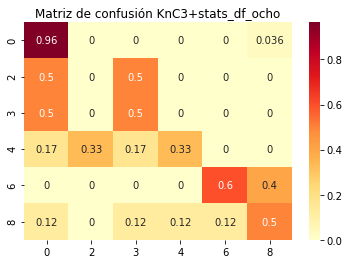

model scvL
              precision    recall  f1-score   support
0              1.000000  0.678571  0.808511  28.00000
2              0.125000  0.500000  0.200000   2.00000
3              0.142857  0.500000  0.222222   2.00000
4              0.333333  0.166667  0.222222   6.00000
6              0.375000  0.600000  0.461538   5.00000
8              0.500000  0.375000  0.428571   8.00000
accuracy       0.549020  0.549020  0.549020   0.54902
macro avg      0.412698  0.470040  0.390511  51.00000
weighted avg   0.713936  0.549020  0.599065  51.00000


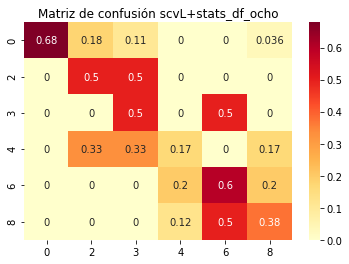

model RF
              precision    recall  f1-score    support
0              0.900000  0.964286  0.931034  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              0.500000  1.000000  0.666667   2.000000
4              1.000000  0.666667  0.800000   6.000000
6              0.500000  0.600000  0.545455   5.000000
8              0.666667  0.500000  0.571429   8.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.761111  0.705159  0.696875  51.000000
weighted avg   0.824183  0.803922  0.800673  51.000000


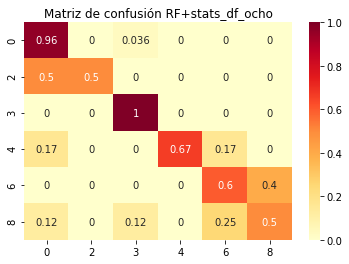

datarame N°: stats_df_seis.xlsx
model KnC3
              precision    recall  f1-score   support
0              0.866667  0.928571  0.896552  28.00000
2              0.000000  0.000000  0.000000   2.00000
3              0.500000  1.000000  0.666667   2.00000
4              0.666667  0.666667  0.666667   6.00000
6              0.400000  0.400000  0.400000   5.00000
8              0.600000  0.375000  0.461538   8.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.505556  0.561706  0.515237  51.00000
weighted avg   0.707190  0.725490  0.708414  51.00000


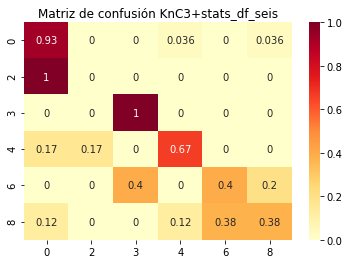

model scvL
              precision    recall  f1-score    support
0              0.916667  0.785714  0.846154  28.000000
2              0.333333  0.500000  0.400000   2.000000
3              0.200000  1.000000  0.333333   2.000000
4              0.000000  0.000000  0.000000   6.000000
6              0.142857  0.200000  0.166667   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.568627  0.568627  0.568627   0.568627
macro avg      0.348810  0.476786  0.362454  51.000000
weighted avg   0.616620  0.568627  0.576880  51.000000


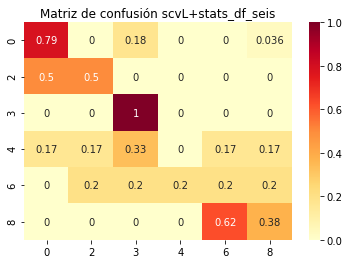

model RF
              precision    recall  f1-score    support
0              0.800000  1.000000  0.888889  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  1.000000  1.000000   2.000000
4              1.000000  0.166667  0.285714   6.000000
6              0.571429  0.800000  0.666667   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.861905  0.661111  0.687220  51.000000
weighted avg   0.816807  0.784314  0.748881  51.000000


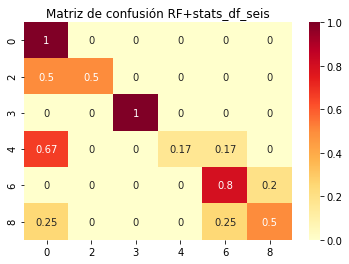

datarame N°: stats_df_siete.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.870968  0.964286  0.915254  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.400000  1.000000  0.571429   2.000000
4              1.000000  0.333333  0.500000   6.000000
6              0.428571  0.600000  0.500000   5.000000
8              0.666667  0.500000  0.571429   8.000000
accuracy       0.745098  0.745098  0.745098   0.745098
macro avg      0.561034  0.566270  0.509685  51.000000
weighted avg   0.758104  0.745098  0.722380  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


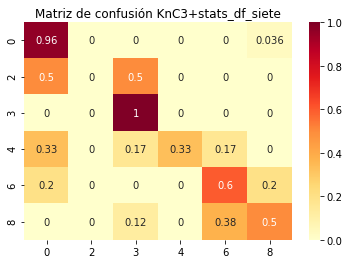

model scvL
              precision    recall  f1-score    support
0              0.909091  0.714286  0.800000  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.090909  0.500000  0.153846   2.000000
4              0.125000  0.166667  0.142857   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.490196  0.490196  0.490196   0.490196
macro avg      0.270833  0.292659  0.254212  51.000000
weighted avg   0.595811  0.490196  0.529282  51.000000


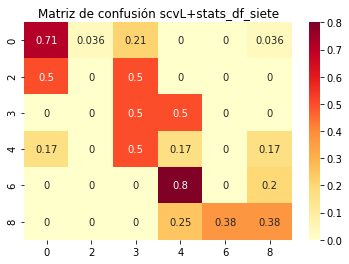

model RF


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score    support
0              0.823529  1.000000  0.903226  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.333333  0.500000  0.400000   2.000000
4              1.000000  0.333333  0.500000   6.000000
6              0.571429  0.800000  0.666667   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.588049  0.522222  0.514213  51.000000
weighted avg   0.764365  0.764706  0.732289  51.000000


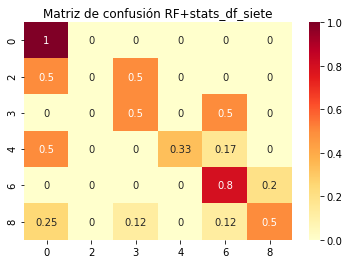

datarame N°: stats_df_tres.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.794118  0.964286  0.870968  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.500000  1.000000  0.666667   2.000000
4              0.750000  0.500000  0.600000   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.571429  0.500000  0.533333   8.000000
accuracy       0.705882  0.705882  0.705882   0.705882
macro avg      0.435924  0.494048  0.445161  51.000000
weighted avg   0.633465  0.705882  0.658571  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


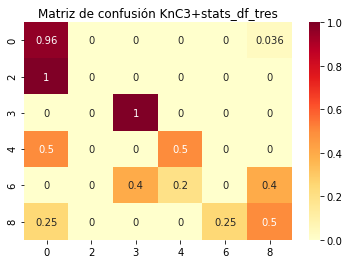

model scvL
              precision    recall  f1-score    support
0              0.954545  0.750000  0.840000  28.000000
2              0.333333  0.500000  0.400000   2.000000
3              0.200000  1.000000  0.333333   2.000000
4              0.500000  0.333333  0.400000   6.000000
6              0.166667  0.200000  0.181818   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.588235  0.588235  0.588235   0.588235
macro avg      0.442424  0.526389  0.430620  51.000000
weighted avg   0.698574  0.588235  0.622046  51.000000


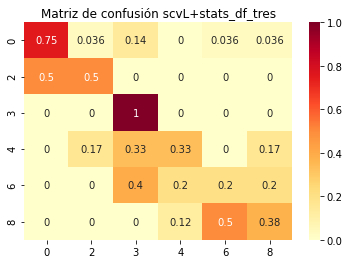

model RF
              precision    recall  f1-score    support
0              0.823529  1.000000  0.903226  28.000000
2              0.500000  0.500000  0.500000   2.000000
3              1.000000  1.000000  1.000000   2.000000
4              0.500000  0.166667  0.250000   6.000000
6              0.666667  0.800000  0.727273   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.715033  0.661111  0.665981  51.000000
weighted avg   0.760631  0.784314  0.751956  51.000000


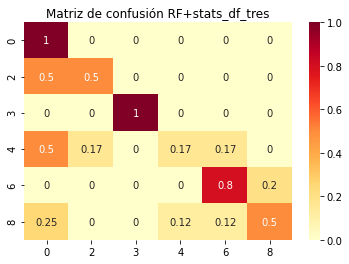

datarame N°: stats_df_uno.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.794118  0.964286  0.870968  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.500000  1.000000  0.666667   2.000000
4              0.750000  0.500000  0.600000   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.571429  0.500000  0.533333   8.000000
accuracy       0.705882  0.705882  0.705882   0.705882
macro avg      0.435924  0.494048  0.445161  51.000000
weighted avg   0.633465  0.705882  0.658571  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


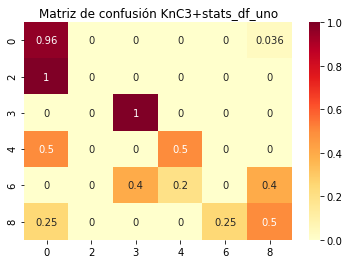

model scvL
              precision    recall  f1-score    support
0              0.958333  0.821429  0.884615  28.000000
2              0.333333  0.500000  0.400000   2.000000
3              0.250000  1.000000  0.400000   2.000000
4              0.333333  0.166667  0.222222   6.000000
6              0.142857  0.200000  0.166667   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.607843  0.607843  0.607843   0.607843
macro avg      0.419643  0.510516  0.417013  51.000000
weighted avg   0.680672  0.607843  0.626754  51.000000


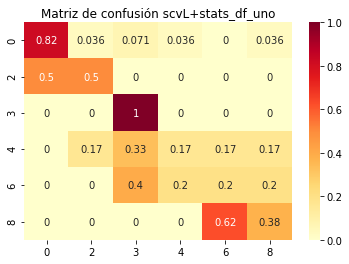

model RF
              precision    recall  f1-score    support
0              0.823529  1.000000  0.903226  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  1.000000  1.000000   2.000000
4              1.000000  0.333333  0.500000   6.000000
6              0.571429  0.800000  0.666667   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.865826  0.688889  0.725324  51.000000
weighted avg   0.829725  0.803922  0.781962  51.000000


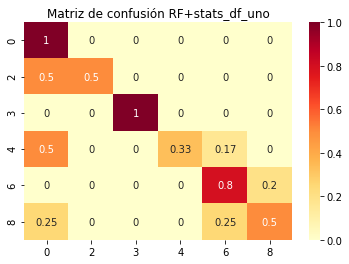

datarame N°: wave_df_cinco.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.750000  0.964286  0.843750  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              0.400000  0.333333  0.363636   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.571429  0.500000  0.533333   8.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.453571  0.382937  0.401231  51.000000
weighted avg   0.587675  0.666667  0.615820  51.000000


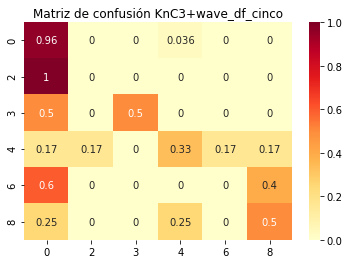

model scvL
              precision    recall  f1-score    support
0              1.000000  0.785714  0.880000  28.000000
2              0.250000  0.500000  0.333333   2.000000
3              0.200000  1.000000  0.333333   2.000000
4              0.166667  0.166667  0.166667   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.333333  0.375000  0.352941   8.000000
accuracy       0.568627  0.568627  0.568627   0.568627
macro avg      0.325000  0.471230  0.344379  51.000000
weighted avg   0.638562  0.568627  0.584252  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


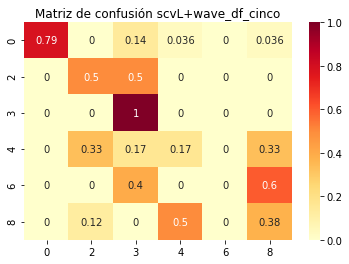

model RF


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score    support
0              0.848485  1.000000  0.918033  28.000000
2              0.500000  0.500000  0.500000   2.000000
3              1.000000  1.000000  1.000000   2.000000
4              0.000000  0.000000  0.000000   6.000000
6              0.666667  0.400000  0.500000   5.000000
8              0.454545  0.625000  0.526316   8.000000
accuracy       0.745098  0.745098  0.745098   0.745098
macro avg      0.578283  0.587500  0.574058  51.000000
weighted avg   0.661319  0.745098  0.694420  51.000000


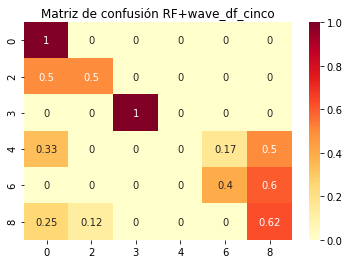

datarame N°: wave_df_cuatro.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.757576  0.892857  0.819672  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              0.285714  0.333333  0.307692   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.444444  0.500000  0.470588   8.000000
accuracy       0.627451  0.627451  0.627451   0.627451
macro avg      0.331289  0.371032  0.349659  51.000000
weighted avg   0.538862  0.627451  0.579641  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


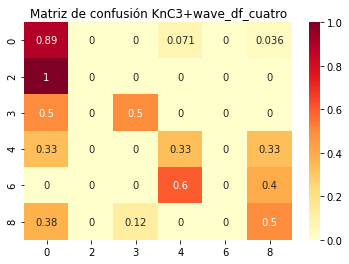

model scvL
              precision    recall  f1-score    support
0              1.000000  0.750000  0.857143  28.000000
2              0.333333  0.500000  0.400000   2.000000
3              0.000000  0.000000  0.000000   2.000000
4              0.142857  0.166667  0.153846   6.000000
6              0.181818  0.400000  0.250000   5.000000
8              0.285714  0.250000  0.266667   8.000000
accuracy       0.529412  0.529412  0.529412   0.529412
macro avg      0.323954  0.344444  0.321276  51.000000
weighted avg   0.641541  0.529412  0.570714  51.000000


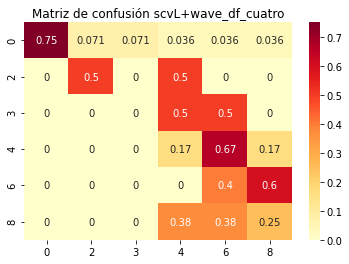

model RF
              precision    recall  f1-score    support
0              0.812500  0.928571  0.866667  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              0.250000  0.166667  0.200000   6.000000
6              0.666667  0.400000  0.500000   5.000000
8              0.555556  0.625000  0.588235   8.000000
accuracy       0.705882  0.705882  0.705882   0.705882
macro avg      0.630787  0.520040  0.553595  51.000000
weighted avg   0.686819  0.705882  0.686390  51.000000


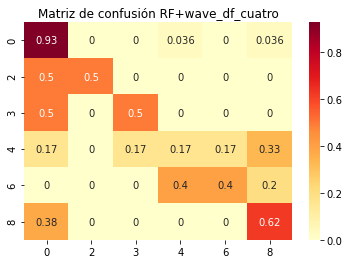

datarame N°: wave_df_dos.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.781250  0.892857  0.833333  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.333333  0.500000  0.400000   2.000000
4              0.500000  0.333333  0.400000   6.000000
6              0.250000  0.200000  0.222222   5.000000
8              0.800000  0.500000  0.615385   8.000000
accuracy       0.647059  0.647059  0.647059   0.647059
macro avg      0.444097  0.404365  0.411823  51.000000
weighted avg   0.650817  0.647059  0.638579  51.000000


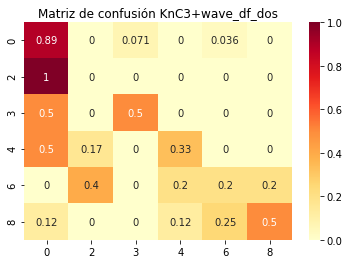

model scvL
              precision    recall  f1-score    support
0              0.952381  0.714286  0.816327  28.000000
2              0.500000  0.500000  0.500000   2.000000
3              0.111111  0.500000  0.181818   2.000000
4              0.333333  0.500000  0.400000   6.000000
6              0.500000  0.400000  0.444444   5.000000
8              0.666667  0.500000  0.571429   8.000000
accuracy       0.607843  0.607843  0.607843   0.607843
macro avg      0.510582  0.519048  0.485670  51.000000
weighted avg   0.739651  0.607843  0.655185  51.000000


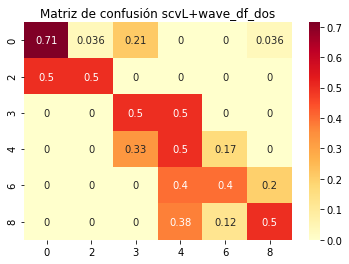

model RF
              precision    recall  f1-score    support
0              0.870968  0.964286  0.915254  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              0.666667  0.666667  0.666667   6.000000
6              0.500000  0.600000  0.545455   5.000000
8              0.500000  0.375000  0.428571   8.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.756272  0.600992  0.648213  51.000000
weighted avg   0.762492  0.764706  0.753914  51.000000


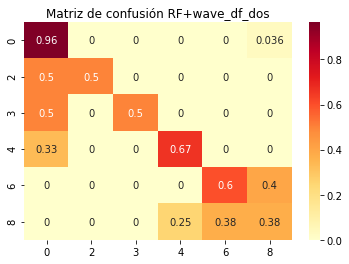

datarame N°: wave_df_ocho.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.634146  0.928571  0.753623  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              0.000000  0.000000  0.000000   6.000000
6              0.333333  0.200000  0.250000   5.000000
8              0.666667  0.250000  0.363636   8.000000
accuracy       0.588235  0.588235  0.588235   0.588235
macro avg      0.355691  0.313095  0.311210  51.000000
weighted avg   0.505022  0.588235  0.514913  51.000000


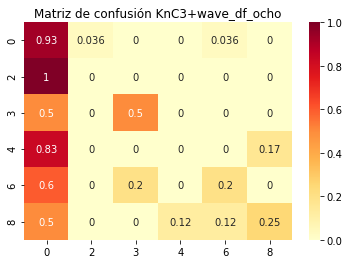

model scvL
              precision    recall  f1-score   support
0              0.863636  0.678571  0.760000  28.00000
2              0.333333  0.500000  0.400000   2.00000
3              0.333333  0.500000  0.400000   2.00000
4              0.133333  0.333333  0.190476   6.00000
6              0.400000  0.400000  0.400000   5.00000
8              1.000000  0.375000  0.545455   8.00000
accuracy       0.549020  0.549020  0.549020   0.54902
macro avg      0.510606  0.464484  0.449322  51.00000
weighted avg   0.712062  0.549020  0.595814  51.00000


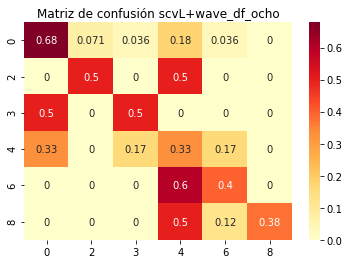

model RF
              precision    recall  f1-score    support
0              0.727273  0.857143  0.786885  28.000000
2              0.333333  0.500000  0.400000   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              0.250000  0.166667  0.200000   6.000000
6              0.500000  0.400000  0.444444   5.000000
8              0.833333  0.625000  0.714286   8.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.607323  0.508135  0.535380  51.000000
weighted avg   0.660725  0.666667  0.652993  51.000000


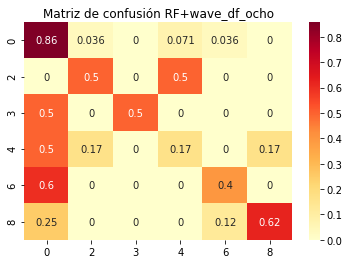

datarame N°: wave_df_seis.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.781250  0.892857  0.833333  28.000000
2              0.500000  0.500000  0.500000   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              0.000000  0.000000  0.000000   6.000000
6              0.333333  0.200000  0.250000   5.000000
8              0.300000  0.375000  0.333333   8.000000
accuracy       0.607843  0.607843  0.607843   0.607843
macro avg      0.402431  0.411310  0.402778  51.000000
weighted avg   0.547876  0.607843  0.573529  51.000000


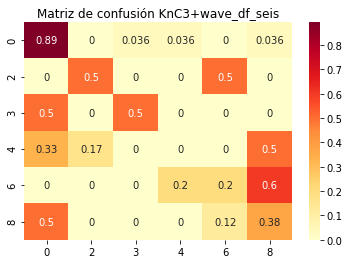

model scvL
              precision    recall  f1-score   support
0              1.000000  0.821429  0.901961  28.00000
2              0.111111  0.500000  0.181818   2.00000
3              0.000000  0.000000  0.000000   2.00000
4              0.000000  0.000000  0.000000   6.00000
6              0.000000  0.000000  0.000000   5.00000
8              0.285714  0.500000  0.363636   8.00000
accuracy       0.549020  0.549020  0.549020   0.54902
macro avg      0.232804  0.303571  0.241236  51.00000
weighted avg   0.598195  0.549020  0.559365  51.00000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


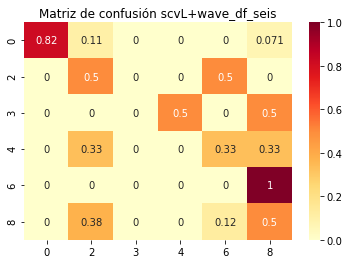

model RF
              precision    recall  f1-score   support
0              0.833333  0.892857  0.862069  28.00000
2              0.500000  0.500000  0.500000   2.00000
3              1.000000  0.500000  0.666667   2.00000
4              0.666667  0.333333  0.444444   6.00000
6              1.000000  0.400000  0.571429   5.00000
8              0.461538  0.750000  0.571429   8.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.743590  0.562698  0.602673  51.00000
weighted avg   0.765209  0.725490  0.716990  51.00000


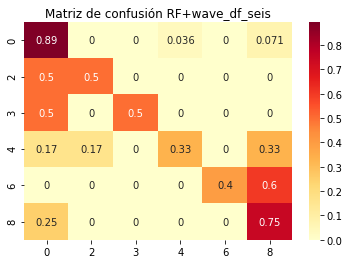

datarame N°: wave_df_siete.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.787879  0.928571  0.852459  28.000000
2              0.250000  0.500000  0.333333   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              0.333333  0.333333  0.333333   6.000000
6              0.500000  0.200000  0.285714   5.000000
8              0.600000  0.375000  0.461538   8.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.578535  0.472817  0.488841  51.000000
weighted avg   0.663933  0.666667  0.646857  51.000000


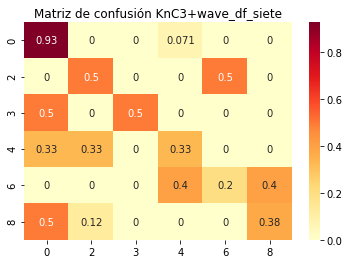

model scvL
              precision    recall  f1-score    support
0              1.000000  0.785714  0.880000  28.000000
2              0.200000  1.000000  0.333333   2.000000
3              0.200000  1.000000  0.333333   2.000000
4              0.000000  0.000000  0.000000   6.000000
6              0.250000  0.200000  0.222222   5.000000
8              0.600000  0.375000  0.461538   8.000000
accuracy       0.588235  0.588235  0.588235   0.588235
macro avg      0.375000  0.560119  0.371738  51.000000
weighted avg   0.683333  0.588235  0.603466  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


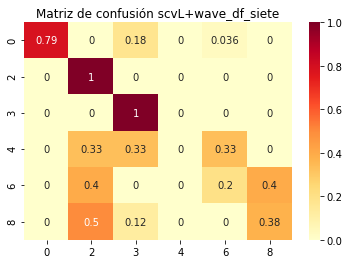

model RF
              precision    recall  f1-score    support
0              0.843750  0.964286  0.900000  28.000000
2              0.500000  0.500000  0.500000   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              1.000000  0.333333  0.500000   6.000000
6              1.000000  0.400000  0.571429   5.000000
8              0.500000  0.750000  0.600000   8.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.807292  0.574603  0.623016  51.000000
weighted avg   0.816176  0.764706  0.748833  51.000000


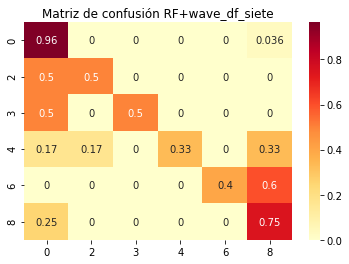

datarame N°: wave_df_tres.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.750000  0.964286  0.843750  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              0.500000  0.333333  0.400000   6.000000
6              0.333333  0.200000  0.250000   5.000000
8              0.333333  0.250000  0.285714   8.000000
accuracy       0.647059  0.647059  0.647059   0.647059
macro avg      0.486111  0.374603  0.407688  51.000000
weighted avg   0.594771  0.647059  0.605766  51.000000


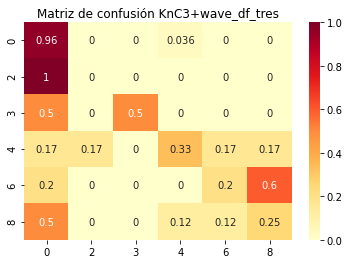

model scvL
              precision    recall  f1-score    support
0              0.950000  0.678571  0.791667  28.000000
2              0.166667  0.500000  0.250000   2.000000
3              0.250000  1.000000  0.400000   2.000000
4              0.285714  0.333333  0.307692   6.000000
6              0.500000  0.400000  0.444444   5.000000
8              0.666667  0.500000  0.571429   8.000000
accuracy       0.588235  0.588235  0.588235   0.588235
macro avg      0.469841  0.568651  0.460872  51.000000
weighted avg   0.725117  0.588235  0.629539  51.000000


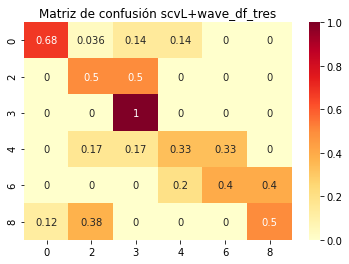

model RF
              precision    recall  f1-score    support
0              0.794118  0.964286  0.870968  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              0.750000  0.500000  0.600000   6.000000
6              1.000000  0.400000  0.571429   5.000000
8              0.555556  0.625000  0.588235   8.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.849946  0.581548  0.660661  51.000000
weighted avg   0.787838  0.764706  0.749349  51.000000


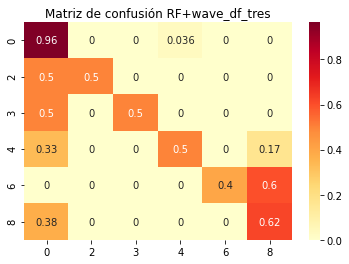

datarame N°: wave_df_uno.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.702703  0.928571  0.800000  28.000000
2              0.000000  0.000000  0.000000   2.000000
3              0.500000  0.500000  0.500000   2.000000
4              0.428571  0.500000  0.461538   6.000000
6              0.000000  0.000000  0.000000   5.000000
8              0.600000  0.375000  0.461538   8.000000
accuracy       0.647059  0.647059  0.647059   0.647059
macro avg      0.371879  0.383929  0.370513  51.000000
weighted avg   0.549943  0.647059  0.585520  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


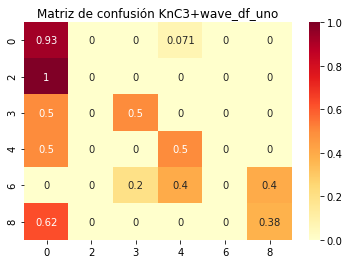

model scvL
              precision    recall  f1-score    support
0              0.952381  0.714286  0.816327  28.000000
2              0.666667  1.000000  0.800000   2.000000
3              0.142857  0.500000  0.222222   2.000000
4              0.200000  0.333333  0.250000   6.000000
6              0.500000  0.400000  0.444444   5.000000
8              0.833333  0.625000  0.714286   8.000000
accuracy       0.627451  0.627451  0.627451   0.627451
macro avg      0.549206  0.595437  0.541213  51.000000
weighted avg   0.757890  0.627451  0.673296  51.000000


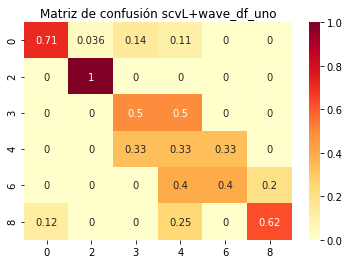

model RF
              precision    recall  f1-score    support
0              0.843750  0.964286  0.900000  28.000000
2              1.000000  0.500000  0.666667   2.000000
3              1.000000  0.500000  0.666667   2.000000
4              1.000000  0.666667  0.800000   6.000000
6              0.500000  0.400000  0.444444   5.000000
8              0.666667  0.750000  0.705882   8.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.835069  0.630159  0.697277  51.000000
weighted avg   0.812908  0.803922  0.794823  51.000000


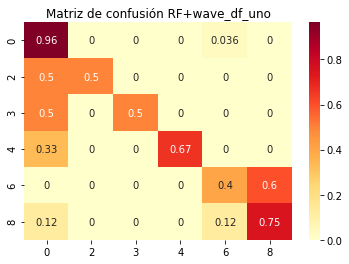

In [12]:
model_supervised_dict = {"KnC3":kn3,"scvL":linear_svc,"RF":rforest}
trained_models_sup_dict = {}
n_models_sup=len(model_supervised_dict)

score_sup= pd.DataFrame()

for fila in range (len(list_df)):
    df_name = list_df[fila][1]
    print("datarame N°:", df_name)   
    df_name=list_df[fila][1]
    df_name=df_name.split(".")[0]
    sub_dict = {} #sub dict va a llenarse de modelos entrenados 
    for model in model_supervised_dict.keys():
        print("model", model)
        each_df= pd.read_excel(main_path+"/"+list_df[fila][1], index_col=0)
        #print(each_df)
        
        sub_dict[model] = supervised_training_models(each_df,score_sup, model_supervised_dict[model],str(model),str(df_name))
        
    trained_models_sup_dict[list_df[fila][1]] = sub_dict



In [13]:
score_unsup

KmC4      KmC3
df_mix_dos       0.611158  0.563750
df_mix_uno       0.613130  0.526416
stats_df_cinco   0.586081  0.524796
stats_df_cuatro  0.615807  0.526416
stats_df_diez    0.567695  0.500000
stats_df_dos     0.613130  0.559312
stats_df_nueve   0.611722  0.500141
stats_df_ocho    0.594181  0.536207
stats_df_seis    0.579177  0.492674
stats_df_siete   0.626092  0.628557
stats_df_tres    0.600240  0.533460
stats_df_uno     0.528881  0.509791
wave_df_cinco    0.589180  0.567554
wave_df_cuatro   0.602071  0.577275
wave_df_dos      0.610242  0.623908
wave_df_ocho     0.592209  0.622006
wave_df_seis     0.616371  0.578332
wave_df_siete    0.600169  0.632432
wave_df_tres     0.599394  0.589884
wave_df_uno      0.608199  0.601014

In [14]:
with pd.ExcelWriter('Comparacion Score_8.xlsx', mode="a", engine="openpyxl") as writer: 
    score_sup.to_excel(writer, sheet_name= "score_sup" )
    score_unsup.to_excel(writer, sheet_name= "score_unsup" )